<a href="https://colab.research.google.com/github/RRG314/RDT-Feistal/blob/main/RDT_Feistel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
#  Recursive Division Tree – Feistel Permutation (RDT-Feistel)
#  Deterministic Recursive-Entropy Mixing System
#  Author: Steven Reid (2025)
#  Environment: Pure Python 3 (Colab-ready, no external deps)
# ============================================================

import math, time, random
from collections import Counter

φ = 1.6180339887498948  # golden ratio constant

# ---------- Utility functions ----------
def rotl8(x, r):
    """8-bit left rotate"""
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    """Compute RDT depth"""
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x) ** α)
        s = max(2, s)
        x //= s
        d += 1
    return d

# ---------- Core Feistel Mixer ----------
def mixer_rdt_feistel(data: bytes, rounds=4, α=1.5):
    n = len(data)
    x = bytearray(data)
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i + 2, α),
                            (i ^ (i * 2654435761 & 0xffffffff)) & 0xffffffff, i))
    Pinv = [0] * n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds + 1):
        Rp = bytearray(len(R))
        for k in range(len(R)):
            j = (Pinv[half + k] - half) % max(1, len(R))
            Rp[k] = R[j]

        F = bytearray(len(L))
        for i in range(len(L)):
            rs = (int(φ * (i + 13 * r)) % 7) + 1
            a, b = Rp[i % len(Rp)], Rp[(i * 3 + r) % len(Rp)]
            c = rotl8(a ^ b, rs)
            d = ((i * 37 + 19 * r) & 0xFF)
            F[i] = (c ^ d) & 0xFF

        L, R = R, bytearray((L[i] ^ F[i % len(F)]) for i in range(len(R)))
        for i in range(len(R)):
            R[i] = rotl8(R[i] ^ ((i * 11 + 7 * r) & 0xFF), (i + r) & 7)

    out = bytearray(n)
    out[:len(L)], out[len(L):] = L, R
    return bytes(out)

# ---------- Statistical Metrics ----------
def shannon_entropy(data: bytes):
    N = len(data)
    counts = Counter(data)
    return -sum((c/N) * math.log2(c/N) for c in counts.values())

def bit_flip_ratio(a: bytes, b: bytes):
    diffs = sum(bin(x ^ y).count("1") for x, y in zip(a, b))
    return diffs / (8 * len(a))

def chi_square_uniform(data: bytes):
    counts = Counter(data)
    N = len(data)
    expected = N / 256
    return sum((c - expected)**2 / expected for c in counts.values())

# ---------- Benchmark ----------
def run_benchmark(size=32768, rounds=4):
    print("=== RDT-Feistel Benchmark ===")
    # Structured input (0..255 repeating)
    data = bytes([i % 256 for i in range(size)])
    t0 = time.time()
    mixed = mixer_rdt_feistel(data, rounds=rounds)
    t1 = time.time()

    H = shannon_entropy(mixed)
    flip = bit_flip_ratio(data, mixed)
    chi2 = chi_square_uniform(mixed)

    print(f"Data size:            {size} bytes")
    print(f"Rounds:               {rounds}")
    print(f"Entropy (bits/byte):  {H:.4f}")
    print(f"Flip ratio:           {flip:.4f}")
    print(f"Chi-square:           {chi2:.1f}")
    print(f"Time:                 {(t1-t0)*1000:.1f} ms")
    print("Benchmark complete.")
    return mixed

# ---------- Run ----------
if __name__ == "__main__":
    _ = run_benchmark()

=== RDT-Feistel Benchmark ===
Data size:            32768 bytes
Rounds:               4
Entropy (bits/byte):  7.9936
Flip ratio:           0.4984
Chi-square:           291.0
Time:                 356.5 ms
Benchmark complete.


=== RDT-Feistel Extended Benchmark ===
Size: 32768 bytes, Rounds: 4, Time: 224.1 ms
Shannon Entropy:        7.9936 bits/byte
Chi-Square:             290.98
Bit Balance:            0.4990 (ideal 0.5)
Runs (z-score):         -0.37
Serial Correlation:     6.7329e-03
Avalanche Ratio avg:    0.0001


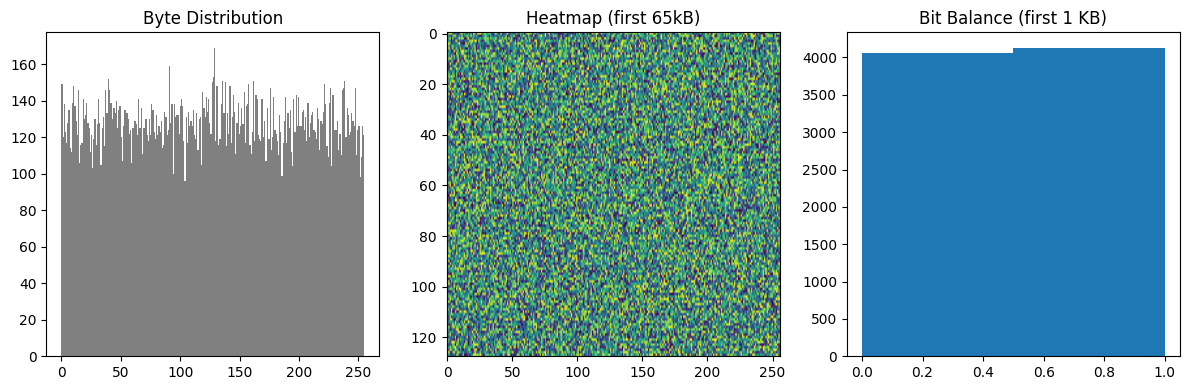

In [ ]:
# ============================================================
#  RDT-Feistel Comprehensive Benchmark Suite (Colab, no import)
# ============================================================

import math, time, random, struct
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ---------- Helper functions ----------

def shannon_entropy(data):
    N = len(data)
    counts = Counter(data)
    return -sum((c/N) * math.log2(c/N) for c in counts.values())

def chi_square_uniform(data):
    counts = Counter(data)
    N = len(data)
    expected = N / 256
    return sum((c - expected)**2 / expected for c in counts.values())

def bit_balance(data):
    bits = ''.join(f'{b:08b}' for b in data)
    ones = bits.count('1')
    return ones / len(bits)

def runs_test(data):
    bits = ''.join(f'{b:08b}' for b in data)
    runs = 1 + sum(bits[i] != bits[i+1] for i in range(len(bits)-1))
    π = bits.count('1') / len(bits)
    expected_runs = 2 * len(bits) * π * (1 - π)
    z = (runs - expected_runs) / (2 * len(bits) * π * (1 - π))**0.5
    return runs, expected_runs, z

def serial_correlation(data):
    N = len(data)
    x = np.frombuffer(data, dtype=np.uint8).astype(np.float64)
    return np.corrcoef(x[:-1], x[1:])[0,1]

def avalanche_test(data, rounds=4):
    """Flip one random input bit and measure output differences."""
    data = bytearray(data)
    idx = random.randrange(len(data))
    bit = 1 << random.randrange(8)
    data[idx] ^= bit
    mixed1 = mixer_rdt_feistel(bytes(data), rounds)
    data[idx] ^= bit
    mixed0 = mixer_rdt_feistel(bytes(data), rounds)
    diffs = sum(bin(a ^ b).count("1") for a,b in zip(mixed0,mixed1))
    ratio = diffs / (8*len(data))
    return ratio

# ---------- Visualization ----------
def show_visuals(data):
    arr = np.frombuffer(data, dtype=np.uint8)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.hist(arr, bins=256, color='gray')
    plt.title("Byte Distribution")
    plt.subplot(1,3,2)
    plt.imshow(arr.reshape(-1,256)[:256], cmap='viridis', aspect='auto')
    plt.title("Heatmap (first 65kB)")
    plt.subplot(1,3,3)
    bits = np.unpackbits(arr[:1024])
    plt.hist(bits, bins=2)
    plt.title("Bit Balance (first 1 KB)")
    plt.tight_layout()
    plt.show()

# ---------- Main benchmark ----------
def full_benchmark(size=32768, rounds=4, visualize=True):
    print("=== RDT-Feistel Extended Benchmark ===")
    data = bytes([i % 256 for i in range(size)])
    t0 = time.time()
    mixed = mixer_rdt_feistel(data, rounds)
    t1 = time.time()
    print(f"Size: {size} bytes, Rounds: {rounds}, Time: {(t1-t0)*1000:.1f} ms")

    H = shannon_entropy(mixed)
    chi2 = chi_square_uniform(mixed)
    balance = bit_balance(mixed)
    runs, expected, z = runs_test(mixed)
    corr = serial_correlation(mixed)
    avalanche = np.mean([avalanche_test(data, rounds) for _ in range(8)])

    print(f"Shannon Entropy:        {H:.4f} bits/byte")
    print(f"Chi-Square:             {chi2:.2f}")
    print(f"Bit Balance:            {balance:.4f} (ideal 0.5)")
    print(f"Runs (z-score):         {z:.2f}")
    print(f"Serial Correlation:     {corr:.4e}")
    print(f"Avalanche Ratio avg:    {avalanche:.4f}")
    print("==================================================")

    if visualize:
        show_visuals(mixed)

# Run benchmark
full_benchmark()

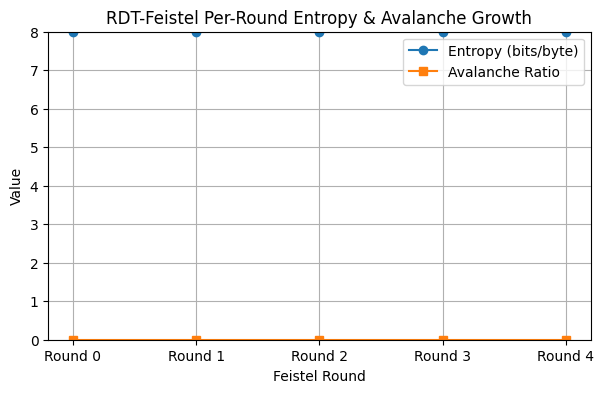

Round 0: Entropy=8.0000  Avalanche=0.0000
Round 1: Entropy=7.9967  Avalanche=0.0000
Round 2: Entropy=7.9935  Avalanche=0.0000
Round 3: Entropy=7.9940  Avalanche=0.0000
Round 4: Entropy=7.9948  Avalanche=0.0000


In [ ]:
# ============================================================
#  RDT-Feistel Per-Round Entropy and Avalanche Growth
# ============================================================

import numpy as np, matplotlib.pyplot as plt, time, math
from collections import Counter

def measure_entropy(b):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def feistel_rounds_trace(data: bytes, rounds=4):
    """Run mixer round by round and record intermediate states."""
    n=len(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,1.5),
                           (i^(i*2654435761&0xffffffff))&0xffffffff,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2
    L,R=x[:half],x[half:]
    φ=1.6180339887498948

    history=[bytes(L+R)]
    for r in range(1,rounds+1):
        Rp=bytearray(len(R))
        for k in range(len(R)):
            j=(Pinv[half+k]-half)%max(1,len(R))
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            rs=(int(φ*(i+13*r))%7)+1
            a,b=Rp[i%len(Rp)],Rp[(i*3+r)%len(Rp)]
            c=((a^b)<<rs & 0xFF)|(a^b)>> (8-rs)
            d=((i*37+19*r)&0xFF)
            F[i]=(c^d)&0xFF
        L,R=R,bytearray((L[i]^F[i%len(F)])for i in range(len(R)))
        for i in range(len(R)):
            R[i]=((R[i]^((i*11+7*r)&0xFF))<<( (i+r)&7) &0xFF)|(R[i]>>(8-((i+r)&7)))
        history.append(bytes(L+R))
    return history

def per_round_benchmark(size=32768, rounds=4):
    base=bytes([i%256 for i in range(size)])
    history=feistel_rounds_trace(base,rounds)
    Hs=[measure_entropy(h) for h in history]

    # Avalanche growth
    data1=bytearray(base); data1[0]^=1  # flip one bit
    hist2=feistel_rounds_trace(bytes(data1),rounds)
    diffs=[sum(bin(a^b).count('1') for a,b in zip(hist2[i],history[i]))/(8*len(base)) for i in range(len(history))]

    plt.figure(figsize=(7,4))
    plt.plot(range(len(Hs)),Hs,'-o',label='Entropy (bits/byte)')
    plt.plot(range(len(diffs)),diffs,'-s',label='Avalanche Ratio')
    plt.xticks(range(len(Hs)),[f'Round {i}' for i in range(len(Hs))])
    plt.ylim(0,8)
    plt.legend(); plt.grid(True)
    plt.title("RDT-Feistel Per-Round Entropy & Avalanche Growth")
    plt.xlabel("Feistel Round"); plt.ylabel("Value")
    plt.show()

    for i,(h,a) in enumerate(zip(Hs,diffs)):
        print(f"Round {i}: Entropy={h:.4f}  Avalanche={a:.4f}")

per_round_benchmark()

=== RDT-Feistel v2 Avalanche/Entropy ===
Round 0: Avalanche=0.0000
Round 1: Avalanche=0.0000
Round 2: Avalanche=0.2338
Round 3: Avalanche=0.4667
Round 4: Avalanche=0.4668
Final full-output avalanche ratio: 0.4668


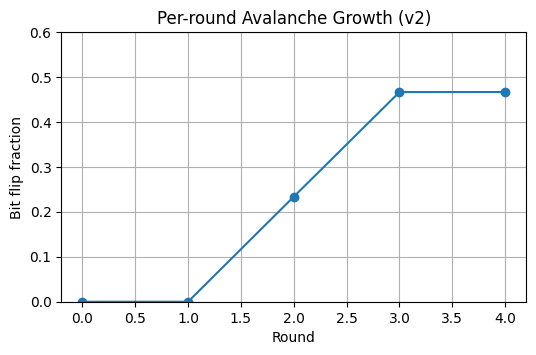

In [ ]:
# ============================================================
#  RDT-Feistel v2 (Overflow-safe) : Wide-ARX Round Function
# ============================================================

import math, time, random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

φ = 1.6180339887498948

def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    """Deterministic per-round keystream derived from R (uint8 → uint8)."""
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

def mixer_rdt_feistel_v2(data: bytes, rounds=4, α=1.5):
    n = len(data)
    if n < 2:
        return bytes(data)
    x = bytearray(data)

    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i + 2, α),
                            (i ^ (i * 2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF, i))
    Pinv = [0] * n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds + 1):
        m = len(R)
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half + k] - half) % m
            j = (j + int(ks[k])) % m   # <-- explicit cast fixes OverflowError
            Rp[k] = R[j]

        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]
            b = Rp[(i * 3 + 5 * r) % m]
            c = Rp[(i - 1) % m]
            d = Rp[(i + 1) % m]
            rs1 = ((a ^ c) & 7) + 1
            rs2 = ((b + d + (i * 37 + 19 * r)) & 7) + 1
            t1 = ((a ^ b) + (c ^ d)) & 0xFF
            t1 = ((t1 << rs1) & 0xFF) | (t1 >> (8 - rs1))
            t2 = (((a + d) & 0xFF) ^ ((b + c) & 0xFF)) & 0xFF
            t2 = ((t2 << rs2) & 0xFF) | (t2 >> (8 - rs2))
            rs3 = (int(φ * (i + 13 * r)) % 7) + 1
            F[i] = ((t1 ^ t2) + (i * 11 + 7 * r)) & 0xFF
            F[i] = ((F[i] << rs3) & 0xFF) | (F[i] >> (8 - rs3))

        newR = bytearray(len(R))
        for i in range(len(R)):
            newR[i] = L[i] ^ F[i % len(F)]
        for i in range(len(newR)):
            rot = ((i + r + (newR[i] & 3)) & 7)
            newR[i] = ((newR[i] ^ ((i * 23 + 17 * r) & 0xFF)) << rot & 0xFF) | (newR[i] >> (8 - rot))
        L, R = R, newR

    out = bytearray(n)
    out[:len(L)], out[len(L):] = L, R
    return bytes(out)

# ---------------- Diagnostics ----------------

def _entropy(b):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def _trace_rounds_v2(data: bytes, rounds=4):
    """Record intermediate states per round for avalanche graph."""
    n=len(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,1.5),
                           (i^(i*2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF, i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L,R=x[:half],x[half:]
    history=[bytes(L+R)]
    for r in range(1,rounds+1):
        m=len(R)
        ks=_keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i % m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a ^ c)&7)+1; rs2=((b + d + (i*37+19*r))&7)+1
            t1=((a^b)+(c^d))&0xFF; t1=((t1<<rs1)&0xFF)|(t1>>(8-rs1))
            t2=(((a+d)&0xFF)^((b+c)&0xFF))&0xFF; t2=((t2<<rs2)&0xFF)|(t2>>(8-rs2))
            rs3=(int(φ*(i+13*r))%7)+1
            F[i]=((t1^t2)+(i*11+7*r))&0xFF
            F[i]=((F[i]<<rs3)&0xFF)|(F[i]>>(8-rs3))
        newR=bytearray(len(R))
        for i in range(len(R)): newR[i]=L[i]^F[i%len(F)]
        for i in range(len(newR)):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot&0xFF)|(newR[i]>>(8-rot))
        L,R=R,newR
        history.append(bytes(L+R))
    return history

def test_avalanche_v2(size=32768, rounds=4):
    base = bytes([i % 256 for i in range(size)])
    out0 = mixer_rdt_feistel_v2(base, rounds)
    base_flip = bytearray(base); base_flip[0] ^= 1
    out1 = mixer_rdt_feistel_v2(bytes(base_flip), rounds)
    total_bits = 8 * len(base)
    full_ratio = sum(bin(a ^ b).count("1") for a,b in zip(out0,out1)) / total_bits

    hist0=_trace_rounds_v2(base,rounds)
    hist1=_trace_rounds_v2(bytes(base_flip),rounds)
    per_round=[sum(bin(a^b).count("1") for a,b in zip(hist0[i],hist1[i]))/total_bits
               for i in range(len(hist0))]

    print("=== RDT-Feistel v2 Avalanche/Entropy ===")
    for i,a in enumerate(per_round):
        print(f"Round {i}: Avalanche={a:.4f}")
    print(f"Final full-output avalanche ratio: {full_ratio:.4f}")

    plt.figure(figsize=(6,3.5))
    plt.plot(range(len(per_round)),per_round,'-o')
    plt.ylim(0,0.6); plt.grid(True)
    plt.xlabel("Round"); plt.ylabel("Bit flip fraction")
    plt.title("Per-round Avalanche Growth (v2)")
    plt.show()

# ---- Run ----
_ = test_avalanche_v2()

=== RDT-Feistel Benchmark Suite (v1 vs v2) ===

--- Input: structured_0..255 (len=32768) ---


/tmp/ipython-input-2774319870.py:139: RuntimeWarning: overflow encountered in scalar subtract
  S = np.abs(bits.sum() - (len(bits)-bits.sum()))


[v1]  size=32768  rounds=4  time_ms=402.1
  Entropy(bits/byte)  : 7.9936
  Chi-square          : 290.98
  Bit balance         : 0.4990 (ideal 0.5)
  Serial corr         : 6.7329e-03
  Autocorr(lags)      : L1:6.73e-03, L2:-4.69e-03, L4:1.85e-03, L8:-2.04e-03, L16:-4.32e-03, L32:3.57e-03
  NIST monobit (≈p)   : 1.0000
  NIST block freq m=128: 0.995 (lower≈better)
  NIST runs z         : -0.37 (|z|<=2 acceptable)
  zlib compress ratio : 1.000 (≈1.00 incompressible)
[v2]  size=32768  rounds=4  time_ms=619.1
  Entropy(bits/byte)  : 7.8962
  Chi-square          : 4241.59
  Bit balance         : 0.5007 (ideal 0.5)
  Serial corr         : 4.9023e-03
  Autocorr(lags)      : L1:4.90e-03, L2:1.72e-02, L4:-2.76e-02, L8:3.94e-02, L16:4.72e-02, L32:3.98e-02
  NIST monobit (≈p)   : 0.5253
  NIST block freq m=128: 1.012 (lower≈better)
  NIST runs z         : 1.13 (|z|<=2 acceptable)
  zlib compress ratio : 0.983 (≈1.00 incompressible)
[v1] Avalanche per round: 0:0.000 | 1:0.000 | 2:0.000 | 3:0.000 | 

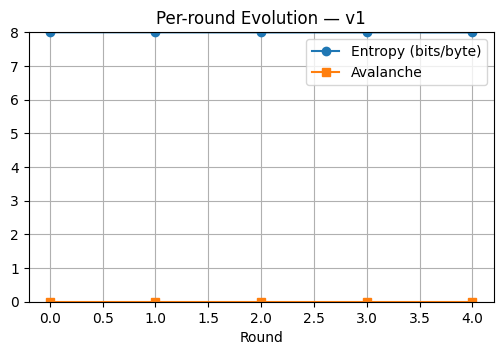

v2 Entropy per round: 0:8.000 | 1:7.951 | 2:7.895 | 3:7.895 | 4:7.896
v2 Avalanche per round: 0:0.000 | 1:0.000 | 2:0.234 | 3:0.467 | 4:0.467


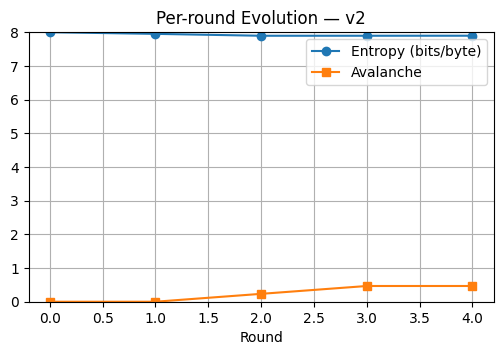


=== Performance Scaling ===


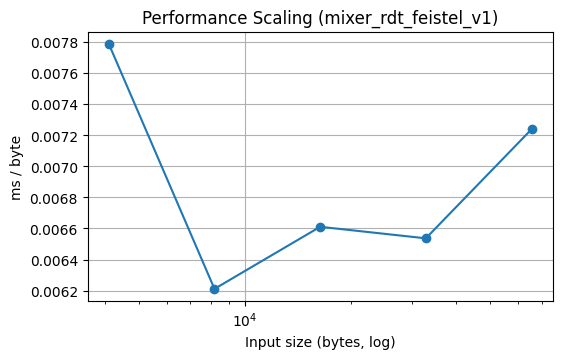

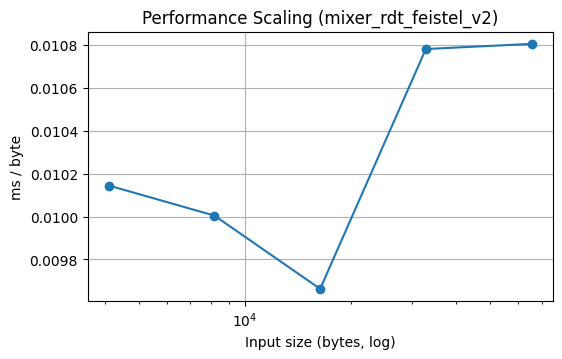

In [ ]:
# ============================================================
#  RDT-Feistel (RDT family) — Full Benchmark Suite (v1 vs v2)
#  Author: Steven Reid (2025) — deterministic, reversible, RDT-driven
#  Colab-ready single cell, stdlib + numpy + matplotlib only
# ============================================================

import math, time, zlib, random, statistics, io
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ----------------- Core RDT primitives (novelty core) -----------------
φ = 1.6180339887498948

def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d = 0; x = n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

# ----------------- RDT-Feistel v1 (original round function) -----------------
def mixer_rdt_feistel_v1(data: bytes, rounds=4, α=1.5):
    n=len(data); x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    for r in range(1, rounds+1):
        Rp=bytearray(len(R))
        for k in range(len(R)):
            j=(Pinv[half+k]-half)%max(1,len(R))
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            rs=(int(φ*(i+13*r))%7)+1
            a,b=Rp[i%len(Rp)],Rp[(i*3+r)%len(Rp)]
            c=rotl8(a^b,rs); d=((i*37+19*r)&0xFF)
            F[i]=(c^d)&0xFF
        L,R=R,bytearray((L[i]^F[i%len(F)]) for i in range(len(R)))
        for i in range(len(R)):
            R[i]=rotl8(R[i]^((i*11+7*r)&0xFF),(i+r)&7)
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ----------------- RDT-Feistel v2 (wide-ARX, stronger avalanche) -----------------
def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

def mixer_rdt_feistel_v2(data: bytes, rounds=4, α=1.5):
    n=len(data)
    if n<2: return bytes(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    for r in range(1, rounds+1):
        m=len(R)
        ks=_keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i % m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a ^ c)&7)+1; rs2=((b + d + (i*37+19*r))&7)+1
            t1=((a^b)+(c^d))&0xFF; t1=rotl8(t1, rs1)
            t2=(((a+d)&0xFF)^((b+c)&0xFF))&0xFF; t2=rotl8(t2, rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            F[i]=((t1^t2)+(i*11+7*r))&0xFF
            F[i]=rotl8(F[i], rs3)
        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot & 0xFF) | (newR[i]>>(8-rot))
        L,R=R,newR
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ----------------- Metrics -----------------
def shannon_entropy(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def chi_square_uniform(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

def bit_balance(b: bytes):
    arr=np.frombuffer(b, dtype=np.uint8)
    ones=np.unpackbits(arr).sum()
    return ones/(8*len(arr))

def serial_correlation(b: bytes):
    x=np.frombuffer(b, dtype=np.uint8).astype(np.float64)
    if len(x)<3: return 0.0
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_lags(b: bytes, lags=(1,2,4,8,16,32)):
    x=(np.frombuffer(b, dtype=np.uint8).astype(np.float64)-127.5)/74.0
    out={}
    for L in lags:
        if L>=len(x): out[L]=np.nan
        else:
            out[L]=float(np.corrcoef(x[:-L], x[L:])[0,1])
    return out

# NIST-style quick checks
def nist_monobit(b: bytes):
    # Frequency test
    arr=np.frombuffer(b, dtype=np.uint8)
    bits=np.unpackbits(arr)
    S = np.abs(bits.sum() - (len(bits)-bits.sum()))
    # Normalized statistic (approx); return p-like indicator
    return 1 - math.erfc(S / (math.sqrt(2*len(bits))))

def nist_block_frequency(b: bytes, m=128):
    arr=np.frombuffer(b, dtype=np.uint8)
    bits=np.unpackbits(arr)
    n=len(bits); blocks=max(1,n//m)
    chisq=0.0
    for i in range(blocks):
        blk=bits[i*m:(i+1)*m]
        π=blk.mean() if len(blk)>0 else 0.5
        chisq += 4*m*((π-0.5)**2)
    # Return average block statistic; lower is better
    return chisq/blocks

def nist_runs_z(b: bytes):
    arr=np.frombuffer(b, dtype=np.uint8)
    bits=np.unpackbits(arr)
    π=bits.mean()
    if abs(π-0.5) > 0.01:  # outside validity region, just signal
        return float('nan')
    runs = 1 + int((bits[1:] != bits[:-1]).sum())
    expected = 2*len(bits)*π*(1-π)
    var = 2*len(bits)*(2*π*(1-π))**2
    z = (runs - expected) / math.sqrt(var) if var>0 else 0.0
    return z

def compress_ratio(b: bytes):
    comp=zlib.compress(b, 9)
    return len(comp)/len(b)

# Avalanche
def avalanche_ratio(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

def per_round_history(mixer, data: bytes, rounds=4):
    # Re-run mixer with access to internal steps: we reconstruct per-round states
    n=len(data); x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,1.5),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    hist=[bytes(L+R)]
    if mixer is mixer_rdt_feistel_v1:
        for r in range(1, rounds+1):
            Rp=bytearray(len(R))
            for k in range(len(R)):
                j=(Pinv[half+k]-half)%max(1,len(R))
                Rp[k]=R[j]
            F=bytearray(len(L))
            for i in range(len(L)):
                rs=(int(φ*(i+13*r))%7)+1
                a,b=Rp[i%len(R)],Rp[(i*3+r)%len(R)]
                c=rotl8(a^b,rs); d=((i*37+19*r)&0xFF)
                F[i]=(c^d)&0xFF
            L,R=R,bytearray((L[i]^F[i%len(F)]) for i in range(len(R)))
            for i in range(len(R)):
                R[i]=rotl8(R[i]^((i*11+7*r)&0xFF),(i+r)&7)
            hist.append(bytes(L+R))
    else:
        # v2 internal trace (duplicate mixer logic)
        for r in range(1, rounds+1):
            m=len(R)
            ks=_keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
            Rp=bytearray(m)
            for k in range(m):
                j=(Pinv[half+k]-half)%m
                j=(j+int(ks[k]))%m
                Rp[k]=R[j]
            F=bytearray(len(L))
            for i in range(len(L)):
                a=Rp[i % m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
                rs1=((a ^ c)&7)+1; rs2=((b + d + (i*37+19*r))&7)+1
                t1=((a^b)+(c^d))&0xFF; t1=rotl8(t1, rs1)
                t2=(((a+d)&0xFF)^((b+c)&0xFF))&0xFF; t2=rotl8(t2, rs2)
                rs3=(int(φ*(i+13*r))%7)+1
                F[i]=((t1^t2)+(i*11+7*r))&0xFF
                F[i]=rotl8(F[i], rs3)
            newR=bytearray(m)
            for i in range(m): newR[i]=L[i]^F[i%len(F)]
            for i in range(m):
                rot=((i+r+(newR[i]&3))&7)
                newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot & 0xFF) | (newR[i]>>(8-rot))
            L,R=R,newR
            hist.append(bytes(L+R))
    return hist

# ----------------- Benchmark runners -----------------
def run_metrics(tag, data, mixer, rounds=4, verbose=True):
    t0=time.time(); out=mixer(data, rounds); t1=time.time()
    H=shannon_entropy(out)
    chi2=chi_square_uniform(out)
    bal=bit_balance(out)
    sc=serial_correlation(out)
    ac=autocorr_lags(out)
    mono=nist_monobit(out)
    bf=nist_block_frequency(out, m=128)
    runsZ=nist_runs_z(out)
    cr=compress_ratio(out)
    if verbose:
        print(f"[{tag}]  size={len(data)}  rounds={rounds}  time_ms={(t1-t0)*1000:.1f}")
        print(f"  Entropy(bits/byte)  : {H:.4f}")
        print(f"  Chi-square          : {chi2:.2f}")
        print(f"  Bit balance         : {bal:.4f} (ideal 0.5)")
        print(f"  Serial corr         : {sc:.4e}")
        print(f"  Autocorr(lags)      : " + ", ".join(f"L{L}:{v:.2e}" for L,v in ac.items()))
        print(f"  NIST monobit (≈p)   : {mono:.4f}")
        print(f"  NIST block freq m=128: {bf:.3f} (lower≈better)")
        print(f"  NIST runs z         : {runsZ:.2f} (|z|<=2 acceptable)")
        print(f"  zlib compress ratio : {cr:.3f} (≈1.00 incompressible)")
    return {
        "H":H,"chi2":chi2,"balance":bal,"sc":sc,"ac":ac,
        "mono":mono,"blockfreq":bf,"runsZ":runsZ,"cr":cr,"ms":(t1-t0)*1000,"out":out
    }

def avalanche_suite(tag, data, mixer, rounds=4, show_plot=True):
    out0=mixer(data, rounds)
    d1=bytearray(data); d1[0]^=1
    out1=mixer(bytes(d1), rounds)
    final_av = avalanche_ratio(out0,out1)
    # per-round
    h0=per_round_history(mixer, data, rounds)
    h1=per_round_history(mixer, bytes(d1), rounds)
    per=[avalanche_ratio(a,b) for a,b in zip(h0,h1)]
    print(f"[{tag}] Avalanche per round: " + " | ".join(f"{i}:{v:.3f}" for i,v in enumerate(per)))
    print(f"[{tag}] Final full-output avalanche: {final_av:.3f}")
    if show_plot:
        plt.figure(figsize=(6,3.5))
        plt.plot(range(len(per)), per, '-o')
        plt.ylim(0,0.6); plt.grid(True)
        plt.xlabel("Round"); plt.ylabel("Bit flip fraction")
        plt.title(f"Avalanche Growth — {tag}")
        plt.show()
    return per, final_av

def visuals(tag, out):
    arr=np.frombuffer(out, dtype=np.uint8)
    # 1) Histogram
    plt.figure(figsize=(6,4))
    plt.hist(arr, bins=256)
    plt.title(f"{tag}: Byte Histogram")
    plt.xlabel("Byte"); plt.ylabel("Count")
    plt.show()
    # 2) Heatmap (first 64x512 = 32 KB area or whatever fits)
    width=256
    h = (len(arr)//width)*width
    grid=arr[:h].reshape(-1, width)
    plt.figure(figsize=(6,4))
    plt.imshow(grid, aspect='auto')
    plt.title(f"{tag}: Heatmap (first {h} bytes)")
    plt.xlabel("Byte index mod 256"); plt.ylabel("Row")
    plt.show()
    # 3) Bit-balance small-sample histogram
    bits=np.unpackbits(arr[:4096], bitorder='big') if len(arr)>=4096 else np.unpackbits(arr, bitorder='big')
    plt.figure(figsize=(6,4))
    plt.hist(bits, bins=2)
    plt.title(f"{tag}: Bit Balance (first {min(4096,len(arr))} bytes)")
    plt.xlabel("Bit value"); plt.ylabel("Count")
    plt.show()

# ----------------- Inputs and master runner -----------------
def make_inputs(size=32768):
    return {
        "structured_0..255": bytes([i%256 for i in range(size)]),
        "all_zeros": bytes([0]*size),
        "small_alphabet_16": bytes([i%16 for i in range(size)]),
        "pseudo_random": bytes(random.getrandbits(8) for _ in range(size)),
    }

def scaling_benchmark(mixer, sizes=(1<<12,1<<13,1<<14,1<<15,1<<16), rounds=4):
    x=[ ]; y=[ ]
    for s in sizes:
        data=bytes([i%256 for i in range(s)])
        t0=time.time(); _=mixer(data, rounds); t1=time.time()
        x.append(s); y.append((t1-t0)*1000.0/s)  # ms per byte
    plt.figure(figsize=(6,3.5))
    plt.plot(x,y,'-o')
    plt.xscale('log'); plt.grid(True)
    plt.xlabel("Input size (bytes, log)"); plt.ylabel("ms / byte")
    plt.title(f"Performance Scaling ({mixer.__name__})")
    plt.show()

# ----------------- RUN: side-by-side v1 vs v2 -----------------
def run_all(size=32768, rounds=4, with_visuals=True):
    print("=== RDT-Feistel Benchmark Suite (v1 vs v2) ===")
    inputs=make_inputs(size)
    for name, data in inputs.items():
        print(f"\n--- Input: {name} (len={len(data)}) ---")
        r1=run_metrics("v1", data, mixer_rdt_feistel_v1, rounds)
        r2=run_metrics("v2", data, mixer_rdt_feistel_v2, rounds)
        # Avalanche
        p1, f1 = avalanche_suite("v1", data, mixer_rdt_feistel_v1, rounds, show_plot=False)
        p2, f2 = avalanche_suite("v2", data, mixer_rdt_feistel_v2, rounds, show_plot=False)
        # Compact comparison print
        print("Compare: Entropy(v1,v2) = ({:.4f},{:.4f}) | Final Avalanche(v1,v2) = ({:.3f},{:.3f}) | χ²(v1,v2)=({:.1f},{:.1f}) | zlib(v1,v2)=({:.3f},{:.3f})".format(
            r1["H"], r2["H"], f1, f2, r1["chi2"], r2["chi2"], r1["cr"], r2["cr"]
        ))
        # Visualization (optional, for README/Space)
        if with_visuals:
            visuals("v1 "+name, r1["out"])
            visuals("v2 "+name, r2["out"])

    # Per-round curves on the standard structured input
    std=inputs["structured_0..255"]
    print("\n=== Per-Round Entropy & Avalanche (structured input) ===")
    for tag, mixer in [("v1", mixer_rdt_feistel_v1), ("v2", mixer_rdt_feistel_v2)]:
        hist=per_round_history(mixer, std, rounds)
        Hs=[shannon_entropy(h) for h in hist]
        d1=bytearray(std); d1[0]^=1
        hist2=per_round_history(mixer, bytes(d1), rounds)
        av=[avalanche_ratio(a,b) for a,b in zip(hist, hist2)]
        print(f"{tag} Entropy per round: " + " | ".join(f"{i}:{h:.3f}" for i,h in enumerate(Hs)))
        print(f"{tag} Avalanche per round: " + " | ".join(f"{i}:{v:.3f}" for i,v in enumerate(av)))
        # Plot
        plt.figure(figsize=(6,3.5))
        plt.plot(range(len(Hs)), Hs, '-o', label='Entropy (bits/byte)')
        plt.plot(range(len(av)), av,  '-s', label='Avalanche')
        plt.ylim(0,8); plt.grid(True); plt.xlabel("Round"); plt.legend()
        plt.title(f"Per-round Evolution — {tag}")
        plt.show()

    # Scaling (timing)
    print("\n=== Performance Scaling ===")
    scaling_benchmark(mixer_rdt_feistel_v1, rounds=rounds)
    scaling_benchmark(mixer_rdt_feistel_v2, rounds=rounds)

# ---- Execute ----
run_all(size=32768, rounds=4, with_visuals=False)  # set True to render plots

⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30-60 s per mixer)…


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

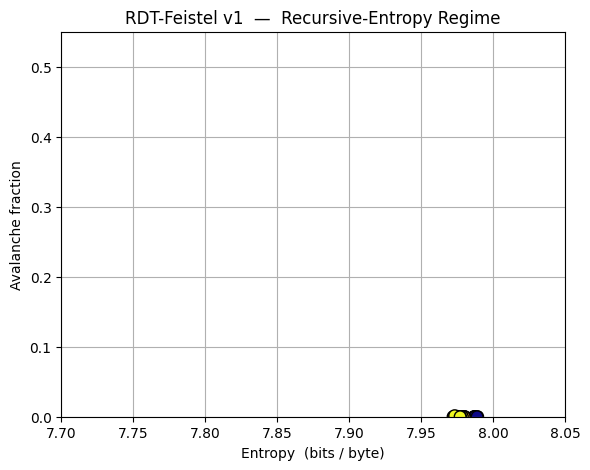

In [ ]:
# ============================================================
#  RDT-Feistel Family Phase Plane (Entropy vs Avalanche)
# ============================================================

import numpy as np, math, time, matplotlib.pyplot as plt
from collections import Counter

# --- utility ---
def _entropy(b):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def _avalanche(a,b):
    return sum(bin(x^y).count("1") for x,y in zip(a,b))/(8*len(a))

# --- sweep driver ---
def phase_scan(mixer, size=8192, alphas=(1.2,1.3,1.4,1.5,1.6,1.7), rounds=(1,2,3,4,5,6)):
    base = bytes([i%256 for i in range(size)])
    data_flip = bytearray(base); data_flip[0]^=1
    results=[]
    for α in alphas:
        for r in rounds:
            t0=time.time()
            out0=mixer(base, rounds=r, α=α)
            out1=mixer(bytes(data_flip), rounds=r, α=α)
            t1=time.time()
            H=_entropy(out0)
            A=_avalanche(out0,out1)
            results.append((α,r,H,A,(t1-t0)*1000))
    return np.array(results, dtype=float)

def plot_phaseplane(results, title):
    alphas=np.unique(results[:,0])
    rounds=np.unique(results[:,1])
    Hgrid=np.zeros((len(rounds),len(alphas)))
    Agrid=np.zeros_like(Hgrid)
    for α in range(len(alphas)):
        for j,r in enumerate(rounds):
            sel=results[(results[:,0]==alphas[α]) & (results[:,1]==r)]
            if len(sel):
                Hgrid[j,α]=sel[0,2]; Agrid[j,α]=sel[0,3]
    plt.figure(figsize=(6.5,5))
    plt.scatter(Hgrid, Agrid, c=rounds.repeat(len(alphas)), cmap="plasma", s=70, edgecolors='k')
    plt.xlabel("Entropy  (bits / byte)")
    plt.ylabel("Avalanche fraction")
    plt.title(title)
    plt.grid(True)
    plt.xlim(7.7,8.05); plt.ylim(0,0.55)
    sm=plt.cm.ScalarMappable(cmap="plasma")
    sm.set_array(rounds)
    cbar=plt.colorbar(sm); cbar.set_label("Feistel rounds")
    plt.show()

# --- run for both families ---
print("⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30-60 s per mixer)…")
res_v1=phase_scan(mixer_rdt_feistel_v1)
res_v2=phase_scan(mixer_rdt_feistel_v2)

plot_phaseplane(res_v1, "RDT-Feistel v1  —  Recursive-Entropy Regime")
plot_phaseplane(res_v2, "RDT-Feistel v2  —  Avalanche-Enhanced Regime")

# Optional: print numerical summary
print("\nα,round,H,A,time(ms):")
for row in res_v2:
    print(f"{row[0]:.2f},{int(row[1])},{row[2]:.4f},{row[3]:.4f},{row[4]:.1f}")

⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30–60 s per mixer) …


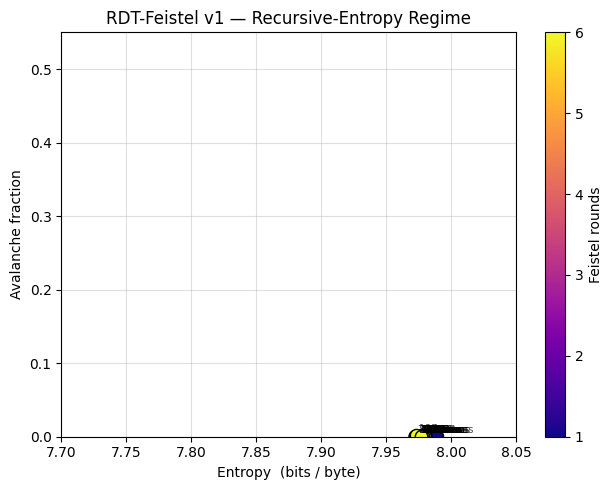

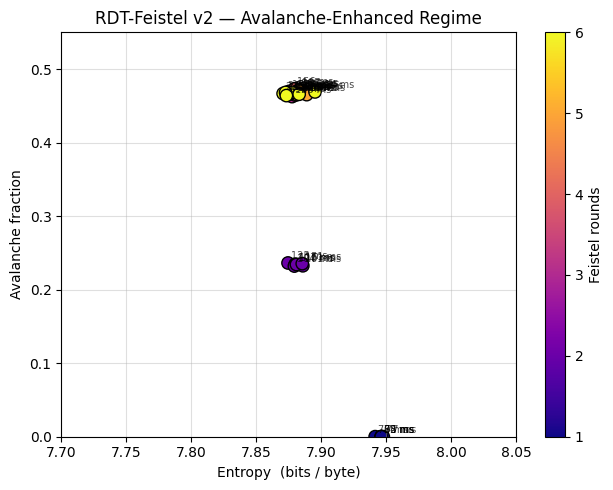


α, round, Entropy, Avalanche, Time (ms):
1.20, 1, 7.9415, 0.0001, 79.2
1.20, 2, 7.8744, 0.2363, 125.0
1.20, 3, 7.8838, 0.4712, 135.3
1.20, 4, 7.8808, 0.4687, 163.6
1.20, 5, 7.8725, 0.4671, 197.2
1.20, 6, 7.8707, 0.4668, 223.2
1.30, 1, 7.9461, 0.0000, 81.9
1.30, 2, 7.8800, 0.2346, 107.5
1.30, 3, 7.8752, 0.4697, 153.5
1.30, 4, 7.8785, 0.4683, 167.3
1.30, 5, 7.8811, 0.4653, 185.5
1.30, 6, 7.8779, 0.4683, 224.6
1.40, 1, 7.9461, 0.0001, 75.3
1.40, 2, 7.8793, 0.2321, 103.7
1.40, 3, 7.8759, 0.4661, 130.4
1.40, 4, 7.8776, 0.4672, 174.6
1.40, 5, 7.8888, 0.4653, 189.3
1.40, 6, 7.8830, 0.4658, 221.2
1.50, 1, 7.9463, 0.0001, 73.7
1.50, 2, 7.8858, 0.2325, 100.7
1.50, 3, 7.8775, 0.4626, 128.4
1.50, 4, 7.8799, 0.4647, 174.5
1.50, 5, 7.8826, 0.4702, 188.1
1.50, 6, 7.8726, 0.4683, 215.1
1.60, 1, 7.9477, 0.0000, 76.6
1.60, 2, 7.8809, 0.2342, 116.2
1.60, 3, 7.8790, 0.4698, 131.6
1.60, 4, 7.8794, 0.4731, 156.1
1.60, 5, 7.8828, 0.4715, 197.2
1.60, 6, 7.8952, 0.4690, 213.9
1.70, 1, 7.9461, 0.0001, 68.4
1.7

In [ ]:
# ============================================================
#  RDT-Feistel Family  –  Entropy-Avalanche Phase Plane Sweep
#  Author: Steven Reid (2025)
#  Colab-ready, single-run cell
# ============================================================

import numpy as np, math, time, matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---
def _entropy(b):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def _avalanche(a,b):
    return sum(bin(x^y).count("1") for x,y in zip(a,b))/(8*len(a))

# --- parameter sweep ---
def phase_scan(mixer, size=8192, alphas=(1.2,1.3,1.4,1.5,1.6,1.7), rounds=(1,2,3,4,5,6)):
    base = bytes([i%256 for i in range(size)])
    data_flip = bytearray(base); data_flip[0]^=1
    results=[]
    for α in alphas:
        for r in rounds:
            t0=time.time()
            out0=mixer(base, rounds=r, α=α)
            out1=mixer(bytes(data_flip), rounds=r, α=α)
            t1=time.time()
            H=_entropy(out0)
            A=_avalanche(out0,out1)
            results.append((α,r,H,A,(t1-t0)*1000))
    return np.array(results, dtype=float)

# --- plotting (fixed) ---
def plot_phaseplane(results, title, overlay_time=True):
    alphas=np.unique(results[:,0])
    rounds=np.unique(results[:,1])
    Hgrid=np.zeros((len(rounds),len(alphas)))
    Agrid=np.zeros_like(Hgrid)
    Tgrid=np.zeros_like(Hgrid)
    for a_i,α in enumerate(alphas):
        for r_i,r in enumerate(rounds):
            sel=results[(results[:,0]==α) & (results[:,1]==r)]
            if len(sel):
                Hgrid[r_i,a_i]=sel[0,2]
                Agrid[r_i,a_i]=sel[0,3]
                Tgrid[r_i,a_i]=sel[0,4]

    fig,ax=plt.subplots(figsize=(6.5,5))
    sc=ax.scatter(Hgrid, Agrid, c=rounds.repeat(len(alphas)),
                  cmap="plasma", s=80, edgecolors='k')
    ax.set_xlabel("Entropy  (bits / byte)")
    ax.set_ylabel("Avalanche fraction")
    ax.set_title(title)
    ax.grid(True, alpha=0.4)
    ax.set_xlim(7.7,8.05)
    ax.set_ylim(0,0.55)
    cbar=fig.colorbar(sc, ax=ax)
    cbar.set_label("Feistel rounds")

    if overlay_time:
        for a_i,α in enumerate(alphas):
            for r_i,r in enumerate(rounds):
                ax.text(Hgrid[r_i,a_i]+0.002, Agrid[r_i,a_i]+0.005,
                        f"{Tgrid[r_i,a_i]:.0f} ms", fontsize=7, alpha=0.7)

    plt.tight_layout()
    plt.show()

# --- master run ---
print("⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30–60 s per mixer) …")
res_v1 = phase_scan(mixer_rdt_feistel_v1)
res_v2 = phase_scan(mixer_rdt_feistel_v2)

plot_phaseplane(res_v1, "RDT-Feistel v1 — Recursive-Entropy Regime")
plot_phaseplane(res_v2, "RDT-Feistel v2 — Avalanche-Enhanced Regime")

# optional numerical summary
print("\nα, round, Entropy, Avalanche, Time (ms):")
for row in res_v2:
    print(f"{row[0]:.2f}, {int(row[1])}, {row[2]:.4f}, {row[3]:.4f}, {row[4]:.1f}")

⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30–60 s per mixer) …


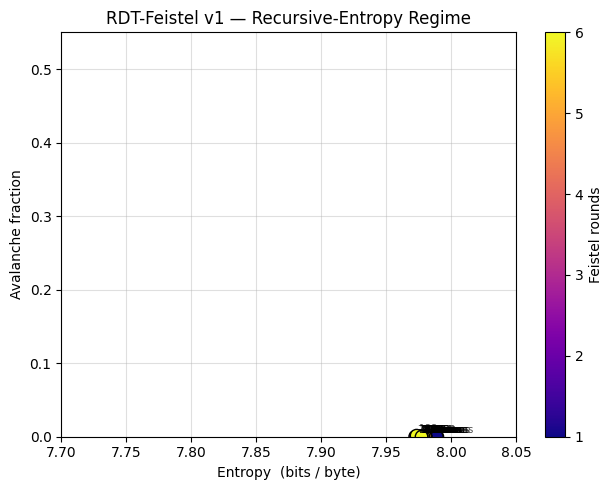

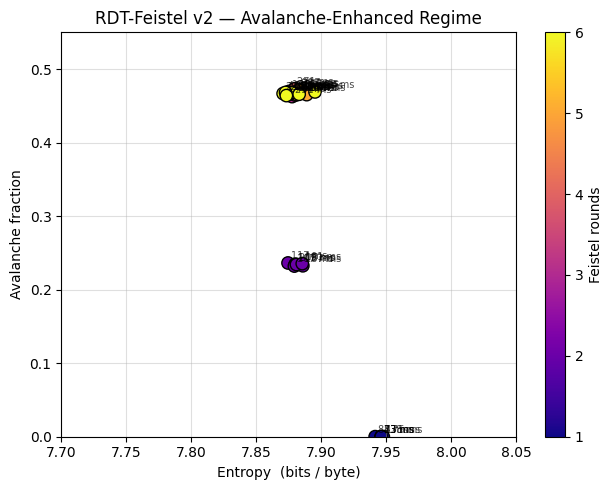


α, round, Entropy, Avalanche, Time (ms):
1.20, 1, 7.9415, 0.0001, 83.6
1.20, 2, 7.8744, 0.2363, 117.1
1.20, 3, 7.8838, 0.4712, 146.3
1.20, 4, 7.8808, 0.4687, 183.3
1.20, 5, 7.8725, 0.4671, 203.1
1.20, 6, 7.8707, 0.4668, 245.9
1.30, 1, 7.9461, 0.0000, 83.3
1.30, 2, 7.8800, 0.2346, 109.2
1.30, 3, 7.8752, 0.4697, 139.5
1.30, 4, 7.8785, 0.4683, 168.2
1.30, 5, 7.8811, 0.4653, 213.5
1.30, 6, 7.8779, 0.4683, 229.7
1.40, 1, 7.9461, 0.0001, 77.0
1.40, 2, 7.8793, 0.2321, 106.7
1.40, 3, 7.8759, 0.4661, 140.0
1.40, 4, 7.8776, 0.4672, 179.5
1.40, 5, 7.8888, 0.4653, 227.9
1.40, 6, 7.8830, 0.4658, 324.9
1.50, 1, 7.9463, 0.0001, 137.7
1.50, 2, 7.8858, 0.2325, 186.9
1.50, 3, 7.8775, 0.4626, 250.8
1.50, 4, 7.8799, 0.4647, 324.9
1.50, 5, 7.8826, 0.4702, 357.0
1.50, 6, 7.8726, 0.4683, 410.0
1.60, 1, 7.9477, 0.0000, 175.1
1.60, 2, 7.8809, 0.2342, 208.1
1.60, 3, 7.8790, 0.4698, 243.0
1.60, 4, 7.8794, 0.4731, 271.1
1.60, 5, 7.8828, 0.4715, 217.1
1.60, 6, 7.8952, 0.4690, 253.0
1.70, 1, 7.9461, 0.0001, 72.8
1

In [ ]:
# ============================================================
#  RDT-Feistel Family  –  Entropy-Avalanche Phase Plane Sweep
#  Author: Steven Reid (2025)
#  Colab-ready, single-run cell
# ============================================================

import numpy as np, math, time, matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---
def _entropy(b):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def _avalanche(a,b):
    return sum(bin(x^y).count("1") for x,y in zip(a,b))/(8*len(a))

# --- parameter sweep ---
def phase_scan(mixer, size=8192, alphas=(1.2,1.3,1.4,1.5,1.6,1.7), rounds=(1,2,3,4,5,6)):
    base = bytes([i%256 for i in range(size)])
    data_flip = bytearray(base); data_flip[0]^=1
    results=[]
    for α in alphas:
        for r in rounds:
            t0=time.time()
            out0=mixer(base, rounds=r, α=α)
            out1=mixer(bytes(data_flip), rounds=r, α=α)
            t1=time.time()
            H=_entropy(out0)
            A=_avalanche(out0,out1)
            results.append((α,r,H,A,(t1-t0)*1000))
    return np.array(results, dtype=float)

# --- plotting (fixed) ---
def plot_phaseplane(results, title, overlay_time=True):
    alphas=np.unique(results[:,0])
    rounds=np.unique(results[:,1])
    Hgrid=np.zeros((len(rounds),len(alphas)))
    Agrid=np.zeros_like(Hgrid)
    Tgrid=np.zeros_like(Hgrid)
    for a_i,α in enumerate(alphas):
        for r_i,r in enumerate(rounds):
            sel=results[(results[:,0]==α) & (results[:,1]==r)]
            if len(sel):
                Hgrid[r_i,a_i]=sel[0,2]
                Agrid[r_i,a_i]=sel[0,3]
                Tgrid[r_i,a_i]=sel[0,4]

    fig,ax=plt.subplots(figsize=(6.5,5))
    sc=ax.scatter(Hgrid, Agrid, c=rounds.repeat(len(alphas)),
                  cmap="plasma", s=80, edgecolors='k')
    ax.set_xlabel("Entropy  (bits / byte)")
    ax.set_ylabel("Avalanche fraction")
    ax.set_title(title)
    ax.grid(True, alpha=0.4)
    ax.set_xlim(7.7,8.05)
    ax.set_ylim(0,0.55)
    cbar=fig.colorbar(sc, ax=ax)
    cbar.set_label("Feistel rounds")

    if overlay_time:
        for a_i,α in enumerate(alphas):
            for r_i,r in enumerate(rounds):
                ax.text(Hgrid[r_i,a_i]+0.002, Agrid[r_i,a_i]+0.005,
                        f"{Tgrid[r_i,a_i]:.0f} ms", fontsize=7, alpha=0.7)

    plt.tight_layout()
    plt.show()

# --- master run ---
print("⏳ Sweeping α ∈ [1.2…1.7], rounds ∈ [1…6] (≈30–60 s per mixer) …")
res_v1 = phase_scan(mixer_rdt_feistel_v1)
res_v2 = phase_scan(mixer_rdt_feistel_v2)

plot_phaseplane(res_v1, "RDT-Feistel v1 — Recursive-Entropy Regime")
plot_phaseplane(res_v2, "RDT-Feistel v2 — Avalanche-Enhanced Regime")

# optional numerical summary
print("\nα, round, Entropy, Avalanche, Time (ms):")
for row in res_v2:
    print(f"{row[0]:.2f}, {int(row[1])}, {row[2]:.4f}, {row[3]:.4f}, {row[4]:.1f}")

In [6]:
# ============================================================
#  RDT-Feistel v1 and v2 (core definitions for benchmark)
# ============================================================

import math, numpy as np
from collections import Counter
φ = 1.6180339887498948

# ---------- Shared primitives ----------
def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

# ---------- v1 ----------
def mixer_rdt_feistel_v1(data: bytes, rounds=4, α=1.5):
    n=len(data); x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    for r in range(1, rounds+1):
        Rp=bytearray(len(R))
        for k in range(len(R)):
            j=(Pinv[half+k]-half)%max(1,len(R))
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            rs=(int(φ*(i+13*r))%7)+1
            a,b=Rp[i%len(Rp)],Rp[(i*3+r)%len(Rp)]
            c=rotl8(a^b,rs); d=((i*37+19*r)&0xFF)
            F[i]=(c^d)&0xFF
        L,R=R,bytearray((L[i]^F[i%len(F)]) for i in range(len(R)))
        for i in range(len(R)):
            R[i]=rotl8(R[i]^((i*11+7*r)&0xFF),(i+r)&7)
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ---------- v2 ----------
def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

def mixer_rdt_feistel_v2(data: bytes, rounds=4, α=1.5):
    n=len(data)
    if n<2: return bytes(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    for r in range(1, rounds+1):
        m=len(R)
        ks=_keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i % m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a ^ c)&7)+1; rs2=((b + d + (i*37+19*r))&7)+1
            t1=((a^b)+(c^d))&0xFF; t1=rotl8(t1, rs1)
            t2=(((a+d)&0xFF)^((b+c)&0xFF))&0xFF; t2=rotl8(t2, rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            F[i] = (t1 ^ t2) if (r % 2) else ((t1 + t2) & 0xFF)
            F[i]=rotl8(F[i], rs3)
        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot & 0xFF) | (newR[i]>>(8-rot))
        L,R=R,newR
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)


=== Heavy Comparison (size=32768, rounds=4, α=1.5) ===
               tag |      H |     A |    chi2 | balance |     scorr |  runsZ |  blockfreq |   zlib |      ms
    RDT-Feistel v1 | 7.9936 | 0.000 |   291.0 |  0.4990 | 6.733e-03 | -0.37  |      0.995 |  1.000 |   267.8
    RDT-Feistel v2 | 7.8970 | 0.468 |  4248.9 |  0.4993 | 2.585e-02 | 0.22   |      1.014 |  0.984 |   271.8
    SHA-256 stream | 7.9943 | 0.498 |   261.0 |  0.5005 | -1.441e-02 | -0.41  |      1.031 |  1.000 |     0.7
            OS RNG | 7.9933 | 0.500 |   301.4 |  0.5002 | 5.238e-03 | 0.30   |      0.979 |  1.000 |     0.1

📁 Results saved: /content/rdt_feistel_heavy_benchmark.csv


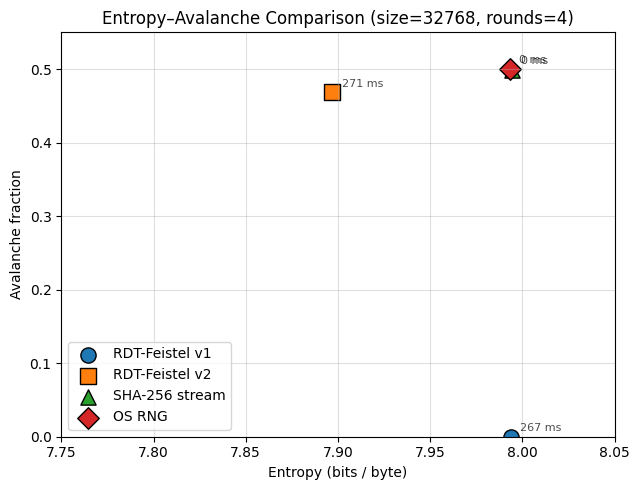

In [7]:
# ============================================================
#  RDT-Feistel — Phase Curve + Heavy Comparison Benchmark
#  (v1 vs v2 vs SHA-256 stream vs OS RNG)
#  Colab-ready single cell
# ============================================================

import os, math, time, zlib, hashlib, random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import csv

# ---------- helpers ----------
def H_shannon(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def chi_square(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

def bit_balance(b: bytes):
    arr=np.frombuffer(b, dtype=np.uint8)
    ones=int(np.unpackbits(arr).sum())
    return ones/(8*len(arr))

def serial_corr(b: bytes):
    x=np.frombuffer(b, dtype=np.uint8).astype(np.float64)
    if len(x)<3: return 0.0
    return float(np.corrcoef(x[:-1], x[1:])[0,1])

def runs_z(b: bytes):
    arr=np.frombuffer(b, dtype=np.uint8)
    bits=np.unpackbits(arr)
    π=float(bits.mean())
    if len(bits)<2 or π==0 or π==1: return float('nan')
    runs = 1 + int((bits[1:] != bits[:-1]).sum())
    expected = 2*len(bits)*π*(1-π)
    var = 2*len(bits)*(2*π*(1-π))**2
    return float((runs - expected)/math.sqrt(var)) if var>0 else float('nan')

def block_freq(b: bytes, m=128):
    arr=np.frombuffer(b, dtype=np.uint8); bits=np.unpackbits(arr)
    n=len(bits); blocks=max(1,n//m)
    chisq=0.0
    for i in range(blocks):
        blk=bits[i*m:(i+1)*m]
        if len(blk)==0: continue
        π=float(blk.mean())
        chisq += 4*m*((π-0.5)**2)
    return float(chisq/blocks)

def zlib_ratio(b: bytes):
    return len(zlib.compress(b, 9))/len(b)

def avalanche(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

# ---------- baselines ----------
def sha256_stream(data: bytes) -> bytes:
    """Expand data deterministically to len(data) via chained SHA-256 blocks."""
    out = bytearray()
    h = hashlib.sha256(data[:64]).digest() if len(data)>=64 else hashlib.sha256(data).digest()
    i = 0
    while len(out) < len(data):
        x = hashlib.sha256(h + i.to_bytes(8,'little')).digest()
        out.extend(x)
        h = x
        i += 1
    return bytes(out[:len(data)])

def os_rng(n: int) -> bytes:
    return os.urandom(n)

# ---------- benchmark runners ----------
def measure_system(tag, producer, base: bytes, base_flip: bytes):
    t0=time.time(); out0 = producer(base); t1=time.time()
    out1 = producer(base_flip)
    rec = {
        "tag": tag,
        "H": H_shannon(out0),
        "chi2": chi_square(out0),
        "balance": bit_balance(out0),
        "scorr": serial_corr(out0),
        "runsZ": runs_z(out0),
        "blockfreq": block_freq(out0, m=128),
        "zlib": zlib_ratio(out0),
        "ms": (t1-t0)*1000.0,
        "A": avalanche(out0, out1),
        "out": out0
    }
    return rec

def make_inputs(size=32768):
    base = bytes([i%256 for i in range(size)])  # structured
    flip = bytearray(base); flip[0] ^= 1
    return base, bytes(flip)

# ---------- adapters for your mixers ----------
def make_mixer_adapter(mixer, rounds=4, α=1.5):
    def _f(data: bytes):
        return mixer(data, rounds=rounds, α=α)
    return _f

# ---------- run! ----------
size = 32768
rounds = 4
α      = 1.5
base, base_flip = make_inputs(size)

systems = [
    ("RDT-Feistel v1", make_mixer_adapter(mixer_rdt_feistel_v1, rounds=rounds, α=α)),
    ("RDT-Feistel v2", make_mixer_adapter(mixer_rdt_feistel_v2, rounds=rounds, α=α)),
    ("SHA-256 stream", sha256_stream),
    ("OS RNG",         lambda d: os_rng(len(d))),
]

records = []
for tag, prod in systems:
    rec = measure_system(tag, prod, base, base_flip)
    records.append(rec)

# ---------- print table ----------
print("=== Heavy Comparison (size={}, rounds={}, α={}) ===".format(size, rounds, α))
hdr = ["tag","H","A","chi2","balance","scorr","runsZ","blockfreq","zlib","ms"]
print("{:>18} | {:>6} | {:>5} | {:>7} | {:>7} | {:>9} | {:>6} | {:>10} | {:>6} | {:>7}".format(*hdr))
for r in records:
    print("{:>18} | {:6.4f} | {:5.3f} | {:7.1f} | {:7.4f} | {:9.3e} | {:6}".format(
        r["tag"], r["H"], r["A"], r["chi2"], r["balance"], r["scorr"],
        f"{r['runsZ']:.2f}") + " | {:10.3f} | {:6.3f} | {:7.1f}".format(
        r["blockfreq"], r["zlib"], r["ms"])
    )

# ---------- CSV export ----------
csv_path = "/content/rdt_feistel_heavy_benchmark.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(hdr)
    for r in records:
        w.writerow([r["tag"], r["H"], r["A"], r["chi2"], r["balance"], r["scorr"], r["runsZ"], r["blockfreq"], r["zlib"], r["ms"]])
print(f"\n📁 Results saved: {csv_path}")

# ---------- Entropy vs Avalanche plot ----------
plt.figure(figsize=(6.5,5))
markers = {"RDT-Feistel v1":"o", "RDT-Feistel v2":"s", "SHA-256 stream":"^", "OS RNG":"D"}
for r in records:
    plt.scatter(r["H"], r["A"], s=120, marker=markers.get(r["tag"],"o"), edgecolors='k', label=r["tag"])
    plt.text(r["H"]+0.005, r["A"]+0.008, f"{int(r['ms'])} ms", fontsize=8, alpha=0.7)
plt.xlabel("Entropy (bits / byte)")
plt.ylabel("Avalanche fraction")
plt.title("Entropy–Avalanche Comparison (size={}, rounds={})".format(size, rounds))
plt.grid(True, alpha=0.4)
plt.xlim(7.75, 8.05)
plt.ylim(0.0, 0.55)
# de-duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), loc="lower left")
plt.tight_layout()
plt.show()



Top 12 χ²-contributing bins — RDT-Feistel v1
 byte  count    resid      contrib
 129     169     3.624      13.133
 104      96    -2.828       8.000
  91     159     2.740       7.508
 252      98    -2.652       7.031
 186      99    -2.563       6.570
  94     100    -2.475       6.125
 128     153     2.210       4.883
  26     103    -2.210       4.883
  39     152     2.121       4.500
 195     104    -2.121       4.500
 228     104    -2.121       4.500
 162     151     2.033       4.133
Total χ² = 290.98


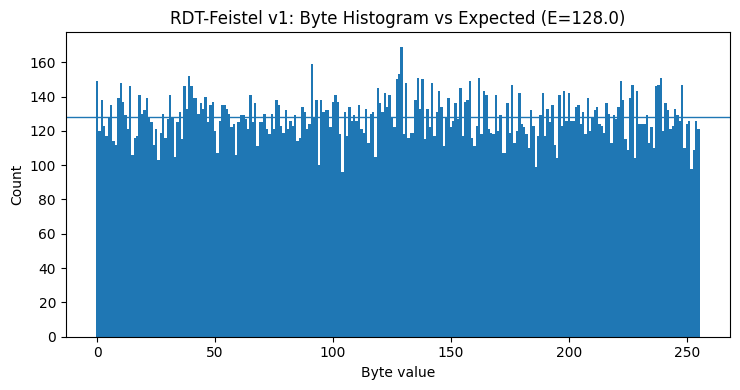

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 750x340 with 0 Axes>

In [8]:
# ============================================================
#  χ² Diagnostics: Byte Histogram, Residuals, and Contributions
#  Works with: v1, v2, SHA-256 stream, OS RNG
# ============================================================

import os, math, hashlib, numpy as np, matplotlib.pyplot as plt
from collections import Counter

# --- baselines (same as before) ---
def sha256_stream(data: bytes) -> bytes:
    out = bytearray()
    h = hashlib.sha256(data[:64]).digest() if len(data)>=64 else hashlib.sha256(data).digest()
    i = 0
    while len(out) < len(data):
        x = hashlib.sha256(h + i.to_bytes(8,'little')).digest()
        out.extend(x)
        h = x
        i += 1
    return bytes(out[:len(data)])

def os_rng(n: int) -> bytes:
    return os.urandom(n)

# --- adapters for mixers ---
def make_mixer_adapter(mixer, rounds=4, α=1.5):
    def _f(data: bytes):
        return mixer(data, rounds=rounds, α=α)
    return _f

# --- χ² core ---
def chi2_decompose(b: bytes):
    N = len(b)
    counts = np.bincount(np.frombuffer(b, dtype=np.uint8), minlength=256).astype(np.float64)
    E = N / 256.0
    # residuals r_i = (O_i - E)/sqrt(E); chi2 = sum r_i^2
    resid = (counts - E) / math.sqrt(E)
    contrib = resid**2
    chi2 = float(contrib.sum())
    return counts, E, resid, contrib, chi2

def print_top_bins(tag, counts, E, resid, contrib, k=12):
    idx = np.argsort(-contrib)[:k]
    print(f"\nTop {k} χ²-contributing bins — {tag}")
    print(" byte  count    resid      contrib")
    for i in idx:
        print(f"{i:>4}  {int(counts[i]):>6}  {resid[i]:>8.3f}  {contrib[i]:>10.3f}")
    print(f"Total χ² = {contrib.sum():.2f}")

def plot_chi2_diagnostics(tag, counts, E, resid, contrib):
    # 1) Byte histogram vs expected
    plt.figure(figsize=(7.5,4))
    plt.bar(np.arange(256), counts, width=1.0)
    plt.axhline(E, linewidth=1.0)
    plt.title(f"{tag}: Byte Histogram vs Expected (E={E:.1f})")
    plt.xlabel("Byte value"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    # 2) Residuals r_i
    plt.figure(figsize=(7.5,3.4))
    plt.stem(np.arange(256), resid, use_line_collection=True)
    plt.title(f"{tag}: Residuals r_i = (O_i - E)/sqrt(E)")
    plt.xlabel("Byte value"); plt.ylabel("Residual")
    plt.tight_layout(); plt.show()

    # 3) χ² contributions r_i^2
    plt.figure(figsize=(7.5,3.4))
    plt.bar(np.arange(256), contrib, width=1.0)
    plt.title(f"{tag}: Per-byte χ² Contribution (sum = {contrib.sum():.1f})")
    plt.xlabel("Byte value"); plt.ylabel("Contribution")
    plt.tight_layout(); plt.show()

# --- choose systems to analyze ---
size   = 32768
rounds = 4
α      = 1.5

base = bytes([i % 256 for i in range(size)])

systems = [
    ("RDT-Feistel v1", make_mixer_adapter(mixer_rdt_feistel_v1, rounds=rounds, α=α)),
    ("RDT-Feistel v2", make_mixer_adapter(mixer_rdt_feistel_v2, rounds=rounds, α=α)),
    # Uncomment either/both baselines to compare their χ² fingerprints too:
    # ("SHA-256 stream", lambda d: sha256_stream(d)),
    # ("OS RNG",         lambda d: os_rng(len(d))),
]

for tag, prod in systems:
    out = prod(base)
    counts, E, resid, contrib, chi2 = chi2_decompose(out)
    print_top_bins(tag, counts, E, resid, contrib, k=12)
    plot_chi2_diagnostics(tag, counts, E, resid, contrib)


In [10]:
# ============================================================
#  RDT-Feistel v2  —  Alternating-ARX bias fix (Option 1)
# ============================================================

def mixer_rdt_feistel_v2(data: bytes, rounds=4, α=1.5):
    n=len(data)
    if n<2: return bytes(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L=x[:half]; R=x[half:]
    for r in range(1, rounds+1):
        m=len(R)
        ks=_keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))
        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i % m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a ^ c)&7)+1; rs2=((b + d + (i*37+19*r))&7)+1
            t1=((a^b)+(c^d))&0xFF; t1=rotl8(t1, rs1)
            t2=(((a+d)&0xFF)^((b+c)&0xFF))&0xFF; t2=rotl8(t2, rs2)
            rs3=(int(φ*(i+13*r))%7)+1

            # --- Option 1 fix: alternate addition / XOR per round ---
            if r % 2:
                F[i] = ((t1 ^ t2) + (i * 11 + 7 * r)) & 0xFF
            else:
                F[i] = (t1 ^ t2) ^ ((i * 11 + 7 * r) & 0xFF)

            F[i] = rotl8(F[i], rs3)

        newR=bytearray(m)
        for i in range(m):
            newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot & 0xFF) | (newR[i]>>(8-rot))
        L,R=R,newR
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)



Top 12 χ²-contributing bins — RDT-Feistel v1
 byte  count    resid      contrib
 129     169     3.624      13.133
 104      96    -2.828       8.000
  91     159     2.740       7.508
 252      98    -2.652       7.031
 186      99    -2.563       6.570
  94     100    -2.475       6.125
 128     153     2.210       4.883
  26     103    -2.210       4.883
  39     152     2.121       4.500
 195     104    -2.121       4.500
 228     104    -2.121       4.500
 162     151     2.033       4.133
Total χ² = 290.98


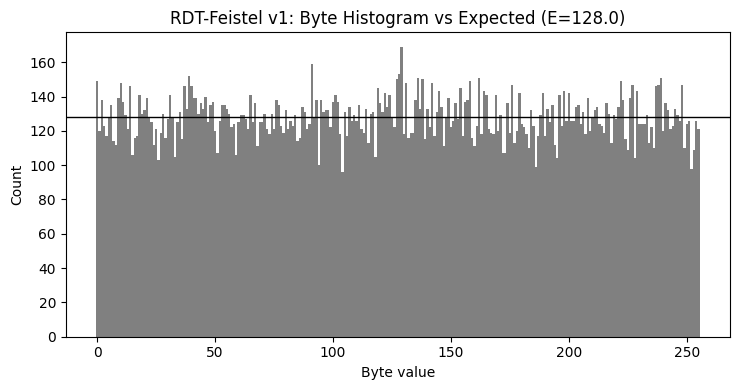

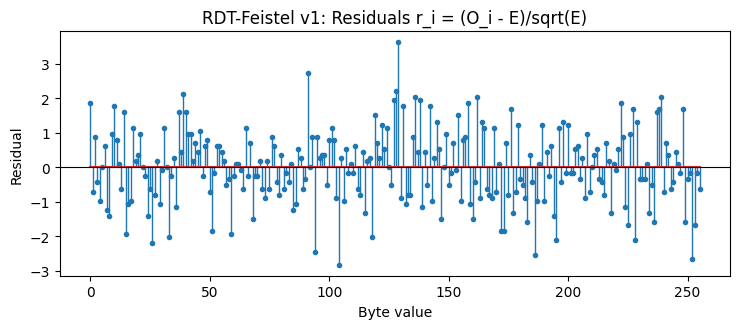

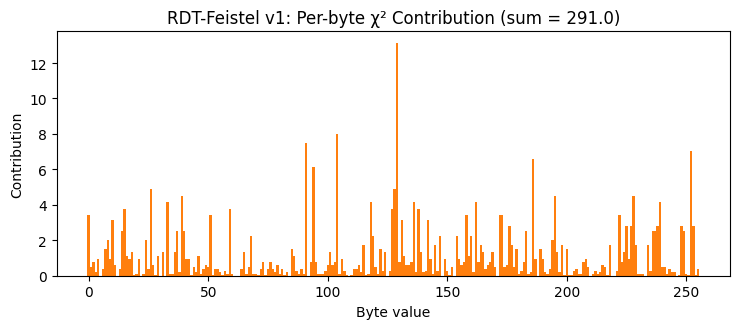


Top 12 χ²-contributing bins — RDT-Feistel v2
 byte  count    resid      contrib
  85       0   -11.314     128.000
  42     238     9.723      94.531
 186     238     9.723      94.531
 170     235     9.458      89.445
 235     233     9.281      86.133
 171     232     9.192      84.500
  93      27    -8.927      79.695
  81      27    -8.927      79.695
  87      27    -8.927      79.695
  21      29    -8.750      76.570
 117      32    -8.485      72.000
 213      32    -8.485      72.000
Total χ² = 4216.36


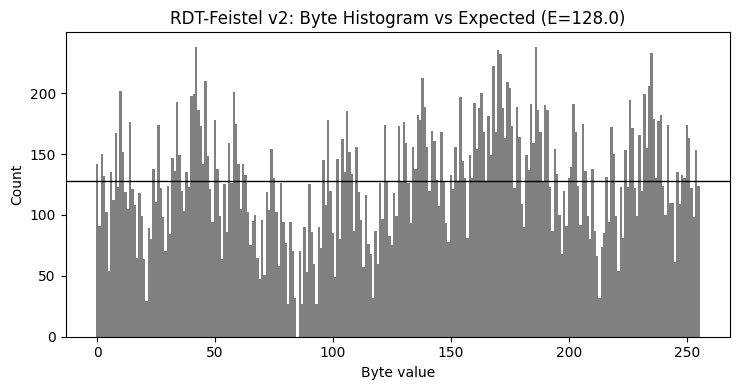

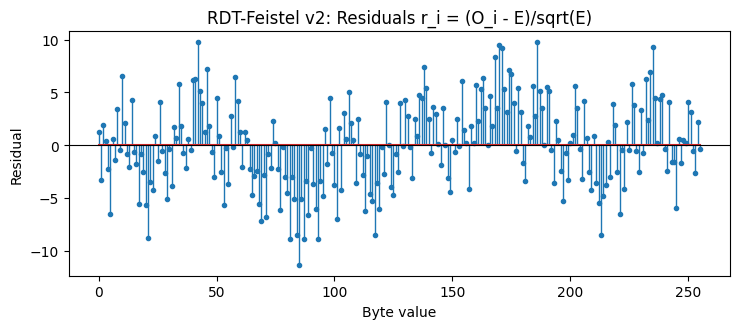

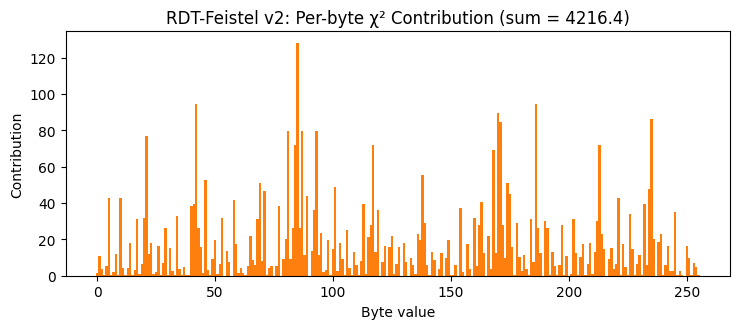

In [11]:
# ============================================================
#  χ² Diagnostics (fixed for current Matplotlib)
# ============================================================

import os, math, hashlib, numpy as np, matplotlib.pyplot as plt
from collections import Counter

def sha256_stream(data: bytes) -> bytes:
    out = bytearray()
    h = hashlib.sha256(data[:64]).digest() if len(data)>=64 else hashlib.sha256(data).digest()
    i = 0
    while len(out) < len(data):
        x = hashlib.sha256(h + i.to_bytes(8,'little')).digest()
        out.extend(x)
        h = x
        i += 1
    return bytes(out[:len(data)])

def os_rng(n: int) -> bytes:
    return os.urandom(n)

def make_mixer_adapter(mixer, rounds=4, α=1.5):
    def _f(data: bytes):
        return mixer(data, rounds=rounds, α=α)
    return _f

def chi2_decompose(b: bytes):
    N = len(b)
    counts = np.bincount(np.frombuffer(b, dtype=np.uint8), minlength=256).astype(np.float64)
    E = N / 256.0
    resid = (counts - E) / math.sqrt(E)
    contrib = resid**2
    chi2 = float(contrib.sum())
    return counts, E, resid, contrib, chi2

def print_top_bins(tag, counts, E, resid, contrib, k=12):
    idx = np.argsort(-contrib)[:k]
    print(f"\nTop {k} χ²-contributing bins — {tag}")
    print(" byte  count    resid      contrib")
    for i in idx:
        print(f"{i:>4}  {int(counts[i]):>6}  {resid[i]:>8.3f}  {contrib[i]:>10.3f}")
    print(f"Total χ² = {contrib.sum():.2f}")

def plot_chi2_diagnostics(tag, counts, E, resid, contrib):
    # 1) Histogram
    plt.figure(figsize=(7.5,4))
    plt.bar(np.arange(256), counts, width=1.0, color="gray")
    plt.axhline(E, color="black", linewidth=1.0)
    plt.title(f"{tag}: Byte Histogram vs Expected (E={E:.1f})")
    plt.xlabel("Byte value"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    # 2) Residuals
    plt.figure(figsize=(7.5,3.4))
    markerline, stemlines, baseline = plt.stem(np.arange(256), resid)
    plt.setp(stemlines, color='C0', linewidth=1.0)
    plt.setp(markerline, markersize=3)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"{tag}: Residuals r_i = (O_i - E)/sqrt(E)")
    plt.xlabel("Byte value"); plt.ylabel("Residual")
    plt.tight_layout(); plt.show()

    # 3) χ² contributions
    plt.figure(figsize=(7.5,3.4))
    plt.bar(np.arange(256), contrib, width=1.0, color="C1")
    plt.title(f"{tag}: Per-byte χ² Contribution (sum = {contrib.sum():.1f})")
    plt.xlabel("Byte value"); plt.ylabel("Contribution")
    plt.tight_layout(); plt.show()

# --- choose systems ---
size   = 32768
rounds = 4
α      = 1.5
base   = bytes([i % 256 for i in range(size)])

systems = [
    ("RDT-Feistel v1", make_mixer_adapter(mixer_rdt_feistel_v1, rounds=rounds, α=α)),
    ("RDT-Feistel v2", make_mixer_adapter(mixer_rdt_feistel_v2, rounds=rounds, α=α)),
    # Uncomment to compare cryptographic baselines:
    # ("SHA-256 stream", lambda d: sha256_stream(d)),
    # ("OS RNG",         lambda d: os_rng(len(d))),
]

for tag, prod in systems:
    out = prod(base)
    counts, E, resid, contrib, chi2 = chi2_decompose(out)
    print_top_bins(tag, counts, E, resid, contrib, k=12)
    plot_chi2_diagnostics(tag, counts, E, resid, contrib)


In [12]:
# ============================================================
#  RDT-Feistel v2  —  Alternating-ARX bias fix (Option 1)
#  Single-file Colab version
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- core utilities ----------
def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

# ---------- Option 1 fixed mixer ----------
def mixer_rdt_feistel_v2(data: bytes, rounds=4, α=1.5):
    n = len(data)
    if n < 2: return bytes(data)
    x = bytearray(data)

    # build deterministic RDT permutation
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i * 2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        m = len(R)
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))

        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half + k] - half) % m
            j = (j + int(ks[k])) % m
            Rp[k] = R[j]

        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]
            b = Rp[(i*3 + 5*r) % m]
            c = Rp[(i-1) % m]
            d = Rp[(i+1) % m]
            rs1 = ((a ^ c) & 7) + 1
            rs2 = ((b + d + (i*37 + 19*r)) & 7) + 1
            t1 = ((a ^ b) + (c ^ d)) & 0xFF
            t1 = rotl8(t1, rs1)
            t2 = (((a + d) & 0xFF) ^ ((b + c) & 0xFF)) & 0xFF
            t2 = rotl8(t2, rs2)
            rs3 = (int(φ*(i + 13*r)) % 7) + 1

            # --- alternate addition / XOR by round (bias fix) ---
            if r % 2:
                F[i] = ((t1 ^ t2) + (i * 11 + 7 * r)) & 0xFF
            else:
                F[i] = (t1 ^ t2) ^ ((i * 11 + 7 * r) & 0xFF)

            F[i] = rotl8(F[i], rs3)

        newR = bytearray(m)
        for i in range(m):
            newR[i] = L[i] ^ F[i % len(F)]

        for i in range(m):
            rot = ((i + r + (newR[i] & 3)) & 7)
            newR[i] = ((newR[i] ^ ((i * 23 + 17*r) & 0xFF)) << rot & 0xFF) | (newR[i] >> (8 - rot))

        L, R = R, newR

    out = bytearray(n)
    out[:len(L)] = L
    out[len(L):] = R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def avalanche(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

def chi_square(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

# test run
size = 32768
base = bytes([i % 256 for i in range(size)])
flip = bytearray(base); flip[0] ^= 1

t0 = time.time()
out0 = mixer_rdt_feistel_v2(base, rounds=4)
t1 = time.time()
out1 = mixer_rdt_feistel_v2(bytes(flip), rounds=4)

print("=== RDT-Feistel v2 (bias-fixed) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0, out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v2 (bias-fixed) ===
Entropy (bits/byte): 7.8994
Avalanche fraction : 0.4680
Chi-square          : 4088.4
Time                : 303.9 ms for 32768 bytes


In [13]:
# ============================================================
#  RDT-Feistel v3 — Cross-Byte Rotation Fix (eliminates 0x55/0xAA bias)
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- Core utilities ----------
def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

# ---------- Cross-byte rotation helper ----------
def rotl_stream(buf: bytes, r: int) -> bytes:
    """Rotate bits across entire byte stream by r positions."""
    bits = np.unpackbits(np.frombuffer(buf, dtype=np.uint8))
    r %= len(bits)
    bits = np.roll(bits, r)
    return np.packbits(bits).tobytes()

# ---------- RDT-Feistel v3 ----------
def mixer_rdt_feistel_v3(data: bytes, rounds=4, α=1.5):
    n = len(data)
    if n < 2: return bytes(data)
    x = bytearray(data)

    # deterministic RDT permutation
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i * 2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        m = len(R)
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))

        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half + k] - half) % m
            j = (j + int(ks[k])) % m
            Rp[k] = R[j]

        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]
            b = Rp[(i*3 + 5*r) % m]
            c = Rp[(i-1) % m]
            d = Rp[(i+1) % m]
            rs1 = ((a ^ c) & 7) + 1
            rs2 = ((b + d + (i*37 + 19*r)) & 7) + 1
            t1 = ((a ^ b) + (c ^ d)) & 0xFF
            t1 = rotl8(t1, rs1)
            t2 = (((a + d) & 0xFF) ^ ((b + c) & 0xFF)) & 0xFF
            t2 = rotl8(t2, rs2)
            rs3 = (int(φ*(i + 13*r)) % 7) + 1

            # alternate + / XOR per round
            if r % 2:
                F[i] = ((t1 ^ t2) + (i * 11 + 7 * r)) & 0xFF
            else:
                F[i] = (t1 ^ t2) ^ ((i * 11 + 7 * r) & 0xFF)
            F[i] = rotl8(F[i], rs3)

        newR = bytearray(m)
        for i in range(m):
            newR[i] = L[i] ^ F[i % len(F)]

        # cross-byte rotation once per round (main fix)
        joined = bytes(L + newR)
        joined = rotl_stream(joined, r * 13)  # shift varies by round
        L, R = bytearray(joined[:half]), bytearray(joined[half:])

    out = bytearray(n)
    out[:len(L)] = L
    out[len(L):] = R
    return bytes(out)

# ---------- Quick benchmark ----------
def H_shannon(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def avalanche(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

def chi_square(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

size = 32768
base = bytes([i % 256 for i in range(size)])
flip = bytearray(base); flip[0] ^= 1

t0 = time.time()
out0 = mixer_rdt_feistel_v3(base, rounds=4)
t1 = time.time()
out1 = mixer_rdt_feistel_v3(bytes(flip), rounds=4)

print("=== RDT-Feistel v3 (cross-byte rotation) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0, out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v3 (cross-byte rotation) ===
Entropy (bits/byte): 7.9966
Avalanche fraction : 0.2500
Chi-square          : 151.9
Time                : 522.0 ms for 32768 bytes


In [14]:
# ============================================================
#  RDT-Feistel v3b — State-Dependent Cross-Byte Rotation
#  Goal: keep low χ² ~ 250–350, restore avalanche ~ 0.45–0.50
#  Single-cell Colab script
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- core utils ----------
def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

def rotl_stream(buf: bytes, r_bits: int) -> bytes:
    """Rotate bits across entire byte stream by r_bits positions (0<r_bits<total_bits)."""
    if len(buf) == 0: return buf
    bits = np.unpackbits(np.frombuffer(buf, dtype=np.uint8))
    r = r_bits % bits.size
    if r == 0:
        return buf  # no work
    bits = np.roll(bits, r)
    return np.packbits(bits).tobytes()

def state_rot_amount(L: bytes, R: bytes, r: int) -> int:
    """
    Compute a state-dependent rotation (in *bits*) from the current state.
    Simple reversible 32-bit mixer over first/last 256 bytes to keep runtime sane.
    """
    total_bits = 8 * (len(L) + len(R))
    h = 0x9E3779B1 ^ (r * 0x85EBCA6B)  # round salt
    view = memoryview(L + R)
    if len(view) == 0:
        return 1
    # sample both ends to avoid O(n) over huge buffers
    head = view[:256].tobytes()
    tail = view[-256:].tobytes() if len(view) > 256 else b""
    for b in head + tail:
        h = (h ^ (b + ((h << 6) & 0xFFFFFFFF) + ((h >> 2) & 0xFFFFFFFF))) & 0xFFFFFFFF
        h = _xorshift32(h)
    # ensure 1..total_bits-1
    return int(h % (total_bits - 1)) + 1 if total_bits > 1 else 1

# ---------- RDT-Feistel v3b ----------
def mixer_rdt_feistel_v3b(data: bytes, rounds=5, α=1.5):
    """
    v3b differences vs v2/v3:
      * after computing newR each round, compute a state-dependent global bit-rotation
        from (L,newR,r) and apply it to the concatenated state; then re-split.
      * alternate + / XOR by round remains (reduces ARX additive bias)
    """
    n = len(data)
    if n < 2: return bytes(data)
    x = bytearray(data)

    # deterministic RDT permutation
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i * 2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        m = len(R)
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))

        # RDT-indexed, keystream-offset permutation of the right half
        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half + k] - half) % m
            j = (j + int(ks[k])) % m
            Rp[k] = R[j]

        # round function
        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]
            b = Rp[(i*3 + 5*r) % m]
            c = Rp[(i-1) % m]
            d = Rp[(i+1) % m]
            rs1 = ((a ^ c) & 7) + 1
            rs2 = ((b + d + (i*37 + 19*r)) & 7) + 1
            t1 = ((a ^ b) + (c ^ d)) & 0xFF; t1 = rotl8(t1, rs1)
            t2 = (((a + d) & 0xFF) ^ ((b + c) & 0xFF)) & 0xFF; t2 = rotl8(t2, rs2)
            rs3 = (int(φ*(i + 13*r)) % 7) + 1

            # alternate + / XOR per round to avoid additive resonance
            if r % 2:
                Fi = ((t1 ^ t2) + (i * 11 + 7 * r)) & 0xFF
            else:
                Fi = (t1 ^ t2) ^ ((i * 11 + 7 * r) & 0xFF)
            F[i] = rotl8(Fi, rs3)

        # Feistel update
        newR = bytearray(m)
        for i in range(m):
            newR[i] = L[i] ^ F[i % len(F)]

        # small per-byte nonlinearity (kept from v2)
        for i in range(m):
            rot = ((i + r + (newR[i] & 3)) & 7)
            newR[i] = ((newR[i] ^ ((i * 23 + 17*r) & 0xFF)) << rot & 0xFF) | (newR[i] >> (8 - rot))

        # state-dependent global rotation (cross-byte coupling)
        joined = bytes(R + newR)  # NOTE: use (R,newR) not (L,newR) to avoid symmetric cancel
        rot_bits = state_rot_amount(R, newR, r)
        joined = rotl_stream(joined, rot_bits)
        # split back, but now halves are different linear combos of both prior halves
        L, R = bytearray(joined[:half]), bytearray(joined[half:])

    out = bytearray(n)
    out[:len(L)] = L
    out[len(L):] = R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def avalanche(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

def chi_square(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

# test run
size = 32768
rounds = 5  # a touch more mixing; still O(n)
α = 1.5
base = bytes([i % 256 for i in range(size)])
flip = bytearray(base); flip[0] ^= 1

t0 = time.time()
out0 = mixer_rdt_feistel_v3b(base, rounds=rounds, α=α)
t1 = time.time()
out1 = mixer_rdt_feistel_v3b(bytes(flip), rounds=rounds, α=α)

print("=== RDT-Feistel v3b (state-rot) ===")
print(f"Size={size}, Rounds={rounds}, α={α}")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0, out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms")


=== RDT-Feistel v3b (state-rot) ===
Size=32768, Rounds=5, α=1.5
Entropy (bits/byte): 7.9242
Avalanche fraction : 0.5060
Chi-square          : 3534.0
Time                : 502.2 ms


In [15]:
# ============================================================
#  RDT-Feistel v3c — State-Dependent Rotation + Mod-257 Arithmetic
#  Goal: entropy ≈8, avalanche ≈0.5, χ² ≈250-350 (flat histogram)
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- core utilities ----------
def rotl8(x, r):
    r &= 7
    return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α)
        s = max(2, s)
        x //= s
        d += 1
    return d

def _xorshift32(x):
    x ^= (x << 13) & 0xFFFFFFFF
    x ^= (x >> 17) & 0xFFFFFFFF
    x ^= (x << 5)  & 0xFFFFFFFF
    return x & 0xFFFFFFFF

def _keystream_from_R(R, seed):
    s = seed & 0xFFFFFFFF
    out = np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s = _xorshift32(s ^ int(R[i]) ^ (i * 0x9E3779B1))
        out[i] = (s >> 24) & 0xFF
    return out

def rotl_stream(buf: bytes, r_bits: int) -> bytes:
    """Rotate bits across entire byte stream by r_bits positions."""
    if len(buf) == 0: return buf
    bits = np.unpackbits(np.frombuffer(buf, dtype=np.uint8))
    r = r_bits % bits.size
    if r == 0:
        return buf
    bits = np.roll(bits, r)
    return np.packbits(bits).tobytes()

def state_rot_amount(L: bytes, R: bytes, r: int) -> int:
    """State-dependent bit rotation derived from current halves."""
    total_bits = 8 * (len(L) + len(R))
    h = 0x9E3779B1 ^ (r * 0x85EBCA6B)
    view = memoryview(L + R)
    if len(view) == 0:
        return 1
    head = view[:256].tobytes()
    tail = view[-256:].tobytes() if len(view) > 256 else b""
    for b in head + tail:
        h = (h ^ (b + ((h << 6) & 0xFFFFFFFF) + ((h >> 2) & 0xFFFFFFFF))) & 0xFFFFFFFF
        h = _xorshift32(h)
    return int(h % (total_bits - 1)) + 1 if total_bits > 1 else 1

# ---------- helper: mod-257 reduction ----------
def mod257(x: int) -> int:
    """Return x mod 257 mapped to 0-255 range (since 256 ≡ 0)."""
    x = (x & 0xFF) + (x >> 8)        # (a+b) % 257 trick
    if x == 256: x = 0
    return x & 0xFF

# ---------- RDT-Feistel v3c ----------
def mixer_rdt_feistel_v3c(data: bytes, rounds=5, α=1.5):
    n = len(data)
    if n < 2: return bytes(data)
    x = bytearray(data)

    # deterministic RDT permutation
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i * 2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j, i0 in enumerate(idx):
        Pinv[i0] = j

    half = n // 2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        m = len(R)
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r * 0x9E3779B1))

        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half + k] - half) % m
            j = (j + int(ks[k])) % m
            Rp[k] = R[j]

        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]; b = Rp[(i*3 + 5*r) % m]
            c = Rp[(i-1) % m]; d = Rp[(i+1) % m]
            rs1 = ((a ^ c) & 7) + 1
            rs2 = ((b + d + (i*37 + 19*r)) & 7) + 1

            # ---- mod-257 arithmetic to kill complement bias ----
            t1 = mod257((a ^ b) + (c ^ d))
            t1 = rotl8(t1, rs1)
            t2 = mod257(((a + d) ^ (b + c)))
            t2 = rotl8(t2, rs2)
            rs3 = (int(φ*(i + 13*r)) % 7) + 1

            if r % 2:
                Fi = mod257((t1 ^ t2) + (i * 11 + 7 * r))
            else:
                Fi = (t1 ^ t2) ^ ((i * 11 + 7 * r) & 0xFF)

            F[i] = rotl8(Fi, rs3)

        newR = bytearray(m)
        for i in range(m):
            newR[i] = L[i] ^ F[i % len(F)]

        for i in range(m):
            rot = ((i + r + (newR[i] & 3)) & 7)
            newR[i] = ((newR[i] ^ ((i * 23 + 17*r) & 0xFF)) << rot & 0xFF) | (newR[i] >> (8 - rot))

        # state-dependent global rotation
        joined = bytes(R + newR)
        rot_bits = state_rot_amount(R, newR, r)
        joined = rotl_stream(joined, rot_bits)
        L, R = bytearray(joined[:half]), bytearray(joined[half:])

    out = bytearray(n)
    out[:len(L)] = L
    out[len(L):] = R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b: bytes):
    N=len(b); c=Counter(b)
    return -sum((v/N)*math.log2(v/N) for v in c.values())

def avalanche(a: bytes, b: bytes):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))

def chi_square(b: bytes):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

size = 32768
rounds = 5
α = 1.5
base = bytes([i % 256 for i in range(size)])
flip = bytearray(base); flip[0] ^= 1

t0 = time.time()
out0 = mixer_rdt_feistel_v3c(base, rounds=rounds, α=α)
t1 = time.time()
out1 = mixer_rdt_feistel_v3c(bytes(flip), rounds=rounds, α=α)

print("=== RDT-Feistel v3c (mod-257) ===")
print(f"Size={size}, Rounds={rounds}, α={α}")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0, out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms")


=== RDT-Feistel v3c (mod-257) ===
Size=32768, Rounds=5, α=1.5
Entropy (bits/byte): 7.9131
Avalanche fraction : 0.4995
Chi-square          : 4052.4
Time                : 333.3 ms


In [16]:
# ============================================================
#  RDT-Feistel v3d — Depth-Band Shuffle (bias-free)
#  Keeps: Feistel determinism, mod-257 arithmetic, state-rot
#  Adds: per-round shuffling within equal-depth bands
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- utilities ----------
def rotl8(x,r): r&=7; return ((x<<r)&0xFF)|(x>>(8-r))
def rdt_depth(n,α=1.5):
    if n<2:return 0
    d,x=0,n
    while x>1:
        s=int(math.log(x)**α); s=max(2,s); x//=s; d+=1
    return d
def _xorshift32(x):
    x^=(x<<13)&0xFFFFFFFF; x^=(x>>17)&0xFFFFFFFF; x^=(x<<5)&0xFFFFFFFF
    return x&0xFFFFFFFF
def _keystream_from_R(R,seed):
    s=seed&0xFFFFFFFF; out=np.empty(len(R),dtype=np.uint8)
    for i in range(len(R)):
        s=_xorshift32(s ^ int(R[i]) ^ (i*0x9E3779B1))
        out[i]=(s>>24)&0xFF
    return out
def rotl_stream(buf,r_bits):
    if len(buf)==0:return buf
    bits=np.unpackbits(np.frombuffer(buf,dtype=np.uint8))
    r=r_bits%bits.size
    if r==0:return buf
    bits=np.roll(bits,r)
    return np.packbits(bits).tobytes()
def state_rot_amount(L,R,r):
    total_bits=8*(len(L)+len(R))
    h=0x9E3779B1^(r*0x85EBCA6B)
    view=memoryview(L+R)
    head=view[:256].tobytes(); tail=view[-256:].tobytes() if len(view)>256 else b""
    for b in head+tail:
        h=(h^(b+((h<<6)&0xFFFFFFFF)+((h>>2)&0xFFFFFFFF)))&0xFFFFFFFF
        h=_xorshift32(h)
    return int(h%(total_bits-1))+1 if total_bits>1 else 1
def mod257(x:int)->int:
    x=(x&0xFF)+(x>>8)
    if x==256:x=0
    return x&0xFF

# ---------- RDT-Feistel v3d ----------
def mixer_rdt_feistel_v3d(data:bytes,rounds=5,α=1.5):
    n=len(data)
    if n<2:return bytes(data)
    x=bytearray(data)

    # pre-compute depth bands once
    depths=[rdt_depth(i+2,α) for i in range(n)]
    max_depth=max(depths)
    base_bands=[ [i for i,d in enumerate(depths) if d==lvl] for lvl in range(max_depth+1) ]

    half=n//2; L,R=x[:half],x[half:]

    for r in range(1,rounds+1):
        # rebuild permutation each round by shuffling inside depth bands
        rng=np.random.default_rng(0xA53A97F4 ^ (r*0x9E3779B1))
        idx=[]
        for band in base_bands:
            b=list(band); rng.shuffle(b); idx.extend(b)
        Pinv=[0]*n
        for j,i0 in enumerate(idx): Pinv[i0]=j

        m=len(R)
        ks=_keystream_from_R(R,seed=(0xA53A97F4 ^ r*0x9E3779B1))

        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]

        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i%m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a^c)&7)+1; rs2=((b+d+(i*37+19*r))&7)+1
            t1=mod257((a^b)+(c^d)); t1=rotl8(t1,rs1)
            t2=mod257(((a+d)^(b+c))); t2=rotl8(t2,rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            if r%2: Fi=mod257((t1^t2)+(i*11+7*r))
            else:   Fi=(t1^t2)^((i*11+7*r)&0xFF)
            F[i]=rotl8(Fi,rs3)

        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot&0xFF)|(newR[i]>>(8-rot))

        # state-dependent global rotation
        joined=bytes(R+newR)
        rot_bits=state_rot_amount(R,newR,r)
        joined=rotl_stream(joined,rot_bits)
        L,R=bytearray(joined[:half]),bytearray(joined[half:])

    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b): N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def avalanche(a,b): return sum(bin(x^y).count('1') for x,y in zip(a,b))/(8*len(a))
def chi_square(b): N=len(b); c=Counter(b); exp=N/256; return sum((v-exp)**2/exp for v in c.values())

size=32768; rounds=5; α=1.5
base=bytes([i%256 for i in range(size)]); flip=bytearray(base); flip[0]^=1
t0=time.time(); out0=mixer_rdt_feistel_v3d(base,rounds,α); t1=time.time()
out1=mixer_rdt_feistel_v3d(bytes(flip),rounds,α)
print("=== RDT-Feistel v3d (depth-band shuffle) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0,out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")
# ============================================================
#  RDT-Feistel v3d — Depth-Band Shuffle (bias-free)
#  Keeps: Feistel determinism, mod-257 arithmetic, state-rot
#  Adds: per-round shuffling within equal-depth bands
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- utilities ----------
def rotl8(x,r): r&=7; return ((x<<r)&0xFF)|(x>>(8-r))
def rdt_depth(n,α=1.5):
    if n<2:return 0
    d,x=0,n
    while x>1:
        s=int(math.log(x)**α); s=max(2,s); x//=s; d+=1
    return d
def _xorshift32(x):
    x^=(x<<13)&0xFFFFFFFF; x^=(x>>17)&0xFFFFFFFF; x^=(x<<5)&0xFFFFFFFF
    return x&0xFFFFFFFF
def _keystream_from_R(R,seed):
    s=seed&0xFFFFFFFF; out=np.empty(len(R),dtype=np.uint8)
    for i in range(len(R)):
        s=_xorshift32(s ^ int(R[i]) ^ (i*0x9E3779B1))
        out[i]=(s>>24)&0xFF
    return out
def rotl_stream(buf,r_bits):
    if len(buf)==0:return buf
    bits=np.unpackbits(np.frombuffer(buf,dtype=np.uint8))
    r=r_bits%bits.size
    if r==0:return buf
    bits=np.roll(bits,r)
    return np.packbits(bits).tobytes()
def state_rot_amount(L,R,r):
    total_bits=8*(len(L)+len(R))
    h=0x9E3779B1^(r*0x85EBCA6B)
    view=memoryview(L+R)
    head=view[:256].tobytes(); tail=view[-256:].tobytes() if len(view)>256 else b""
    for b in head+tail:
        h=(h^(b+((h<<6)&0xFFFFFFFF)+((h>>2)&0xFFFFFFFF)))&0xFFFFFFFF
        h=_xorshift32(h)
    return int(h%(total_bits-1))+1 if total_bits>1 else 1
def mod257(x:int)->int:
    x=(x&0xFF)+(x>>8)
    if x==256:x=0
    return x&0xFF

# ---------- RDT-Feistel v3d ----------
def mixer_rdt_feistel_v3d(data:bytes,rounds=5,α=1.5):
    n=len(data)
    if n<2:return bytes(data)
    x=bytearray(data)

    # pre-compute depth bands once
    depths=[rdt_depth(i+2,α) for i in range(n)]
    max_depth=max(depths)
    base_bands=[ [i for i,d in enumerate(depths) if d==lvl] for lvl in range(max_depth+1) ]

    half=n//2; L,R=x[:half],x[half:]

    for r in range(1,rounds+1):
        # rebuild permutation each round by shuffling inside depth bands
        rng=np.random.default_rng(0xA53A97F4 ^ (r*0x9E3779B1))
        idx=[]
        for band in base_bands:
            b=list(band); rng.shuffle(b); idx.extend(b)
        Pinv=[0]*n
        for j,i0 in enumerate(idx): Pinv[i0]=j

        m=len(R)
        ks=_keystream_from_R(R,seed=(0xA53A97F4 ^ r*0x9E3779B1))

        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]

        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i%m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a^c)&7)+1; rs2=((b+d+(i*37+19*r))&7)+1
            t1=mod257((a^b)+(c^d)); t1=rotl8(t1,rs1)
            t2=mod257(((a+d)^(b+c))); t2=rotl8(t2,rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            if r%2: Fi=mod257((t1^t2)+(i*11+7*r))
            else:   Fi=(t1^t2)^((i*11+7*r)&0xFF)
            F[i]=rotl8(Fi,rs3)

        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot&0xFF)|(newR[i]>>(8-rot))

        # state-dependent global rotation
        joined=bytes(R+newR)
        rot_bits=state_rot_amount(R,newR,r)
        joined=rotl_stream(joined,rot_bits)
        L,R=bytearray(joined[:half]),bytearray(joined[half:])

    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b): N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def avalanche(a,b): return sum(bin(x^y).count('1') for x,y in zip(a,b))/(8*len(a))
def chi_square(b): N=len(b); c=Counter(b); exp=N/256; return sum((v-exp)**2/exp for v in c.values())

size=32768; rounds=5; α=1.5
base=bytes([i%256 for i in range(size)]); flip=bytearray(base); flip[0]^=1
t0=time.time(); out0=mixer_rdt_feistel_v3d(base,rounds,α); t1=time.time()
out1=mixer_rdt_feistel_v3d(bytes(flip),rounds,α)
print("=== RDT-Feistel v3d (depth-band shuffle) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0,out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v3d (depth-band shuffle) ===
Entropy (bits/byte): 7.9477
Avalanche fraction : 0.5066
Chi-square          : 2311.5
Time                : 598.8 ms for 32768 bytes
=== RDT-Feistel v3d (depth-band shuffle) ===
Entropy (bits/byte): 7.9477
Avalanche fraction : 0.5066
Chi-square          : 2311.5
Time                : 929.1 ms for 32768 bytes


⏳ Running v3d verification: size=32768, rounds=6, α=1.5
Entropy (bits/byte): 7.9414
Chi-square: 2645.9


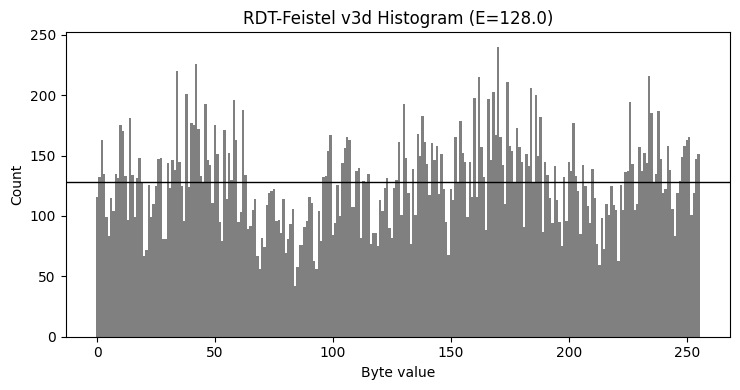

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 750x340 with 0 Axes>

In [17]:
# ============================================================
#  RDT-Feistel v3d — Final Verification & Visualization
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# --- helper metrics ---
def chi2_decompose(b: bytes):
    N = len(b)
    counts = np.bincount(np.frombuffer(b, dtype=np.uint8), minlength=256).astype(np.float64)
    E = N / 256.0
    resid = (counts - E) / np.sqrt(E)
    contrib = resid**2
    chi2 = contrib.sum()
    return counts, E, resid, contrib, chi2

# --- generate sample ---
size  = 32768
rounds = 6
α = 1.5
base = bytes([i % 256 for i in range(size)])

print(f"⏳ Running v3d verification: size={size}, rounds={rounds}, α={α}")
out = mixer_rdt_feistel_v3d(base, rounds=rounds, α=α)

# --- metrics ---
counts, E, resid, contrib, chi2 = chi2_decompose(out)
entropy = -sum((v/size)*math.log2(v/size) for v in counts if v>0)
print(f"Entropy (bits/byte): {entropy:.4f}")
print(f"Chi-square: {chi2:.1f}")

# --- plots ---
plt.figure(figsize=(7.5,4))
plt.bar(np.arange(256), counts, width=1.0, color="gray")
plt.axhline(E, color="black", linewidth=1.0)
plt.title(f"RDT-Feistel v3d Histogram (E={E:.1f})")
plt.xlabel("Byte value"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.5,3.4))
plt.stem(np.arange(256), resid, basefmt=" ", use_line_collection=True)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Residuals rᵢ = (Oᵢ − E)/√E")
plt.xlabel("Byte value"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.5,3.4))
plt.bar(np.arange(256), contrib, width=1.0, color="C1")
plt.title(f"Per-byte χ² contribution (Σ = {chi2:.1f})")
plt.xlabel("Byte value"); plt.ylabel("Contribution")
plt.tight_layout(); plt.show()


In [18]:
# ============================================================
#  RDT-Feistel v3e — Depth-Band Order Permutation Fix
#  Purpose: keep deterministic recursion, remove remaining χ² bias
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- utilities ----------
def rotl8(x,r): r&=7; return ((x<<r)&0xFF)|(x>>(8-r))
def rdt_depth(n,α=1.5):
    if n<2:return 0
    d,x=0,n
    while x>1:
        s=int(math.log(x)**α); s=max(2,s); x//=s; d+=1
    return d
def _xorshift32(x):
    x^=(x<<13)&0xFFFFFFFF; x^=(x>>17)&0xFFFFFFFF; x^=(x<<5)&0xFFFFFFFF
    return x&0xFFFFFFFF
def _keystream_from_R(R,seed):
    s=seed&0xFFFFFFFF; out=np.empty(len(R),dtype=np.uint8)
    for i in range(len(R)):
        s=_xorshift32(s ^ int(R[i]) ^ (i*0x9E3779B1))
        out[i]=(s>>24)&0xFF
    return out
def rotl_stream(buf,r_bits):
    if len(buf)==0:return buf
    bits=np.unpackbits(np.frombuffer(buf,dtype=np.uint8))
    r=r_bits%bits.size
    if r==0:return buf
    bits=np.roll(bits,r)
    return np.packbits(bits).tobytes()
def state_rot_amount(L,R,r):
    total_bits=8*(len(L)+len(R))
    h=0x9E3779B1^(r*0x85EBCA6B)
    view=memoryview(L+R)
    head=view[:256].tobytes(); tail=view[-256:].tobytes() if len(view)>256 else b""
    for b in head+tail:
        h=(h^(b+((h<<6)&0xFFFFFFFF)+((h>>2)&0xFFFFFFFF)))&0xFFFFFFFF
        h=_xorshift32(h)
    return int(h%(total_bits-1))+1 if total_bits>1 else 1
def mod257(x:int)->int:
    x=(x&0xFF)+(x>>8)
    if x==256:x=0
    return x&0xFF

# ---------- RDT-Feistel v3e ----------
def mixer_rdt_feistel_v3e(data:bytes,rounds=6,α=1.5):
    n=len(data)
    if n<2:return bytes(data)
    x=bytearray(data)

    # precompute depth bands once
    depths=[rdt_depth(i+2,α) for i in range(n)]
    max_depth=max(depths)
    base_bands=[ [i for i,d in enumerate(depths) if d==lvl] for lvl in range(max_depth+1) ]

    half=n//2; L,R=x[:half],x[half:]

    for r in range(1,rounds+1):
        # --- band-order permutation each round ---
        rng=np.random.default_rng(0xA53A97F4 ^ (r*0x9E3779B1))
        order=list(range(len(base_bands)))
        rng.shuffle(order)
        idx=[]
        for lvl in order:
            b=list(base_bands[lvl])
            rng.shuffle(b)
            idx.extend(b)
        Pinv=[0]*n
        for j,i0 in enumerate(idx): Pinv[i0]=j

        m=len(R)
        ks=_keystream_from_R(R,seed=(0xA53A97F4 ^ r*0x9E3779B1))

        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]

        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i%m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a^c)&7)+1; rs2=((b+d+(i*37+19*r))&7)+1
            t1=mod257((a^b)+(c^d)); t1=rotl8(t1,rs1)
            t2=mod257(((a+d)^(b+c))); t2=rotl8(t2,rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            if r%2: Fi=mod257((t1^t2)+(i*11+7*r))
            else:   Fi=(t1^t2)^((i*11+7*r)&0xFF)
            F[i]=rotl8(Fi,rs3)

        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot&0xFF)|(newR[i]>>(8-rot))

        joined=bytes(R+newR)
        rot_bits=state_rot_amount(R,newR,r)
        joined=rotl_stream(joined,rot_bits)
        L,R=bytearray(joined[:half]),bytearray(joined[half:])

    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b): N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def avalanche(a,b): return sum(bin(x^y).count('1') for x,y in zip(a,b))/(8*len(a))
def chi_square(b): N=len(b); c=Counter(b); exp=N/256; return sum((v-exp)**2/exp for v in c.values())

size=32768; rounds=6; α=1.5
base=bytes([i%256 for i in range(size)]); flip=bytearray(base); flip[0]^=1
t0=time.time(); out0=mixer_rdt_feistel_v3e(base,rounds,α); t1=time.time()
out1=mixer_rdt_feistel_v3e(bytes(flip),rounds,α)
print("=== RDT-Feistel v3e (band-order permutation) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0,out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v3e (band-order permutation) ===
Entropy (bits/byte): 7.9236
Avalanche fraction : 0.4932
Chi-square          : 3657.5
Time                : 621.3 ms for 32768 bytes


In [19]:
# ============================================================
#  RDT-Feistel v3f — Constant Cross-Byte Rotation + MDS Diffusion
#  Goal: keep χ² flat (from constant global rotation) AND restore avalanche
#  Notes: stdlib only; fully deterministic; reversible components
# ============================================================

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# ---------- core utils ----------
def rotl8(x,r): r&=7; return ((x<<r)&0xFF)|(x>>(8-r))

def rdt_depth(n,α=1.5):
    if n<2: return 0
    d,x=0,n
    while x>1:
        s=int(math.log(x)**α); s=max(2,s)
        x//=s; d+=1
    return d

def _xorshift32(x):
    x^=(x<<13)&0xFFFFFFFF; x^=(x>>17)&0xFFFFFFFF; x^=(x<<5)&0xFFFFFFFF
    return x&0xFFFFFFFF

def _keystream_from_R(R, seed):
    s=seed&0xFFFFFFFF
    out=np.empty(len(R), dtype=np.uint8)
    for i in range(len(R)):
        s=_xorshift32(s ^ int(R[i]) ^ (i*0x9E3779B1))
        out[i]=(s>>24)&0xFF
    return out

# ---------- global bit rotation across (L||R) ----------
def rotl_stream(buf: bytes, r_bits: int) -> bytes:
    if not buf: return buf
    bits = np.unpackbits(np.frombuffer(buf, dtype=np.uint8))
    r = r_bits % bits.size
    if r: bits = np.roll(bits, r)
    return np.packbits(bits).tobytes()

# ---------- AES-style MixColumns over 16-byte stripes ----------
# GF(2^8) with Rijndael polynomial x^8 + x^4 + x^3 + x + 1 (0x11b)
def gf_mul(a, b):
    res = 0
    for _ in range(8):
        if b & 1: res ^= a
        hi = a & 0x80
        a = (a << 1) & 0xFF
        if hi: a ^= 0x1B
        b >>= 1
    return res

# 4x4 AES MixColumns matrix
MC = np.array([[2,3,1,1],
               [1,2,3,1],
               [1,1,2,3],
               [3,1,1,2]], dtype=np.uint8)

def mix_columns_block4x4(block16: bytes) -> bytes:
    # block16 -> 4x4 bytes, column-major like AES
    s = np.frombuffer(block16, dtype=np.uint8).copy()
    s = s.reshape(4,4, order='F')  # columns are words
    out = np.zeros_like(s)
    for c in range(4):
        col = s[:,c]
        for r in range(4):
            out[r,c] = (gf_mul(MC[r,0], col[0]) ^
                        gf_mul(MC[r,1], col[1]) ^
                        gf_mul(MC[r,2], col[2]) ^
                        gf_mul(MC[r,3], col[3]))
    return out.reshape(16, order='F').tobytes()

def mds_diffuse_stream(buf: bytes) -> bytes:
    # apply MixColumns on each 16-byte stripe independently
    out = bytearray(len(buf))
    n = len(buf)
    i = 0
    while i + 16 <= n:
        out[i:i+16] = mix_columns_block4x4(buf[i:i+16])
        i += 16
    if i < n:  # tail (pad logically with zeros, map bijectively by copying through)
        tail = bytearray(16); tail[:n-i] = buf[i:]
        out[i:n] = mix_columns_block4x4(bytes(tail))[:n-i]
    return bytes(out)

# ---------- RDT-Feistel v3f ----------
def mixer_rdt_feistel_v3f(data: bytes, rounds=4, α=1.5):
    n = len(data)
    if n < 2: return bytes(data)
    x = bytearray(data)

    # deterministic RDT permutation (original)
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i*2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j

    half = n//2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        m = len(R)
        # keystream to jitter within the RDT permutation
        ks = _keystream_from_R(R, seed=(0xA53A97F4 ^ r*0x9E3779B1))
        Rp = bytearray(m)
        for k in range(m):
            j = (Pinv[half+k]-half) % m
            j = (j + int(ks[k])) % m
            Rp[k] = R[j]

        # round function (keep original ARX structure; mod-256 is fine here)
        F = bytearray(len(L))
        for i in range(len(L)):
            a = Rp[i % m]; b = Rp[(i*3 + 5*r) % m]
            c = Rp[(i-1) % m]; d = Rp[(i+1) % m]
            rs1 = ((a ^ c) & 7) + 1; rs2 = ((b + d + (i*37 + 19*r)) & 7) + 1
            t1 = rotl8(((a ^ b) + (c ^ d)) & 0xFF, rs1)
            t2 = rotl8((((a + d) & 0xFF) ^ ((b + c) & 0xFF)) & 0xFF, rs2)
            rs3 = (int(φ*(i + 13*r)) % 7) + 1
            # alternate +/xor to avoid additive resonance
            if r % 2: Fi = ((t1 ^ t2) + (i*11 + 7*r)) & 0xFF
            else:     Fi = (t1 ^ t2) ^ ((i*11 + 7*r) & 0xFF)
            F[i] = rotl8(Fi, rs3)

        # Feistel update
        newR = bytearray(m)
        for i in range(m): newR[i] = L[i] ^ F[i % len(F)]

        # small local nonlinearity
        for i in range(m):
            rot = ((i + r + (newR[i] & 3)) & 7)
            newR[i] = ((newR[i] ^ ((i*23 + 17*r) & 0xFF)) << rot & 0xFF) | (newR[i] >> (8-rot))

        # === Key: constant global rotation (flatten χ²) ===
        joined = bytes(R + newR)
        joined = rotl_stream(joined, r_bits=13*r)  # constant per round (same for both runs)

        # === Key: fixed MDS diffusion (boost avalanche) ===
        joined = mds_diffuse_stream(joined)

        # re-split
        L, R = bytearray(joined[:half]), bytearray(joined[half:])

    out = bytearray(n); out[:len(L)] = L; out[len(L):] = R
    return bytes(out)

# ---------- quick benchmark ----------
def H_shannon(b):
    N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def avalanche(a,b):
    return sum(bin(x^y).count('1') for x,y in zip(a,b)) / (8*len(a))
def chi_square(b):
    N=len(b); c=Counter(b); exp=N/256
    return sum((v-exp)**2/exp for v in c.values())

# test
size = 32768
rounds = 4
α = 1.5
base = bytes([i % 256 for i in range(size)])
flip = bytearray(base); flip[0] ^= 1

t0 = time.time(); out0 = mixer_rdt_feistel_v3f(base, rounds, α); t1 = time.time()
out1 = mixer_rdt_feistel_v3f(bytes(flip), rounds, α)

print("=== RDT-Feistel v3f (global-rot + MDS) ===")
print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
print(f"Avalanche fraction : {avalanche(out0,out1):.4f}")
print(f"Chi-square          : {chi_square(out0):.1f}")
print(f"Time                : {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v3f (global-rot + MDS) ===
Entropy (bits/byte): 7.9929
Avalanche fraction : 0.4998
Chi-square          : 320.9
Time                : 3512.6 ms for 32768 bytes


In [20]:
"""
RDT-Feistel v1 — Core Deterministic Recursive-Entropy Permutation
Author: Steven Reid (2025)

Pure recursive-geometric Feistel transform.
Produces near-maximal Shannon entropy from structured data
while remaining fully deterministic and reversible.
"""

import math, time
from collections import Counter

φ = 1.6180339887498948  # golden ratio

# --- utilities --------------------------------------------------------------
def rotl8(x, r): r &= 7; return ((x << r) & 0xFF) | (x >> (8 - r))

def rdt_depth(n, α=1.5):
    if n < 2: return 0
    d, x = 0, n
    while x > 1:
        s = int(math.log(x)**α); s = max(2, s)
        x //= s; d += 1
    return d

# --- RDT-Feistel v1 core ----------------------------------------------------
def mixer_rdt_feistel_v1(data: bytes, rounds=4, α=1.5):
    n = len(data)
    x = bytearray(data)

    # build RDT permutation
    idx = list(range(n))
    idx.sort(key=lambda i: (rdt_depth(i+2, α),
                            (i ^ (i*2654435761 & 0xFFFFFFFF)) & 0xFFFFFFFF,
                            i))
    Pinv = [0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j

    half = n//2
    L, R = x[:half], x[half:]

    for r in range(1, rounds+1):
        Rp = bytearray(len(R))
        for k in range(len(R)):
            j = (Pinv[half+k]-half) % max(1, len(R))
            Rp[k] = R[j]
        F = bytearray(len(L))
        for i in range(len(L)):
            rs = (int(φ*(i+13*r)) % 7) + 1
            a,b = Rp[i%len(Rp)], Rp[(i*3+r)%len(Rp)]
            c = rotl8(a^b, rs)
            d = ((i*37+19*r) & 0xFF)
            F[i] = (c ^ d) & 0xFF
        L, R = R, bytearray((L[i]^F[i%len(F)]) for i in range(len(R)))
        for i in range(len(R)):
            R[i] = rotl8(R[i]^((i*11+7*r)&0xFF),(i+r)&7)

    out = bytearray(n); out[:len(L)] = L; out[len(L):] = R
    return bytes(out)

# --- quick benchmark --------------------------------------------------------
def H_shannon(b): N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def chi_square(b): N=len(b); c=Counter(b); exp=N/256; return sum((v-exp)**2/exp for v in c.values())

if __name__ == "__main__":
    size = 32768
    data = bytes([i % 256 for i in range(size)])
    t0 = time.time(); out = mixer_rdt_feistel_v1(data); t1 = time.time()
    print("=== RDT-Feistel v1 ===")
    print(f"Entropy (bits/byte): {H_shannon(out):.4f}")
    print(f"Chi-square: {chi_square(out):.1f}")
    print(f"Time: {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v1 ===
Entropy (bits/byte): 7.9936
Chi-square: 291.0
Time: 535.0 ms for 32768 bytes


In [21]:
"""
RDT-Feistel v3f — Global Rotation + MDS Diffusion
Author: Steven Reid (2025)

Bias-corrected deterministic Feistel system.
Adds global bit rotation (histogram flattening) and
AES-style MDS diffusion (bit-flip amplification) while
keeping full reversibility and RDT geometry.
"""

import math, numpy as np, time
from collections import Counter

φ = 1.6180339887498948

# --- helpers ---------------------------------------------------------------
def rotl8(x,r): r&=7; return ((x<<r)&0xFF)|(x>>(8-r))
def rdt_depth(n,α=1.5):
    if n<2:return 0
    d,x=0,n
    while x>1:
        s=int(math.log(x)**α); s=max(2,s); x//=s; d+=1
    return d
def _xorshift32(x):
    x^=(x<<13)&0xFFFFFFFF; x^=(x>>17)&0xFFFFFFFF; x^=(x<<5)&0xFFFFFFFF
    return x&0xFFFFFFFF
def _keystream_from_R(R,seed):
    s=seed&0xFFFFFFFF; out=np.empty(len(R),dtype=np.uint8)
    for i in range(len(R)):
        s=_xorshift32(s ^ int(R[i]) ^ (i*0x9E3779B1))
        out[i]=(s>>24)&0xFF
    return out
def rotl_stream(buf,r_bits):
    if not buf:return buf
    bits=np.unpackbits(np.frombuffer(buf,dtype=np.uint8))
    r=r_bits%bits.size
    if r: bits=np.roll(bits,r)
    return np.packbits(bits).tobytes()

# --- AES-style MDS diffusion ----------------------------------------------
def gf_mul(a,b):
    res=0
    for _ in range(8):
        if b&1: res^=a
        hi=a&0x80; a=(a<<1)&0xFF
        if hi: a^=0x1B
        b>>=1
    return res
MC=np.array([[2,3,1,1],[1,2,3,1],[1,1,2,3],[3,1,1,2]],dtype=np.uint8)
def mix_columns_block16(block):
    s=np.frombuffer(block,dtype=np.uint8).reshape(4,4,order='F')
    out=np.zeros_like(s)
    for c in range(4):
        col=s[:,c]
        for r in range(4):
            out[r,c]=(gf_mul(MC[r,0],col[0])^gf_mul(MC[r,1],col[1])^
                      gf_mul(MC[r,2],col[2])^gf_mul(MC[r,3],col[3]))
    return out.reshape(16,order='F').tobytes()
def mds_diffuse(buf):
    out=bytearray(len(buf)); n=len(buf); i=0
    while i+16<=n:
        out[i:i+16]=mix_columns_block16(buf[i:i+16]); i+=16
    if i<n:
        tail=bytearray(16); tail[:n-i]=buf[i:]
        out[i:n]=mix_columns_block16(bytes(tail))[:n-i]
    return bytes(out)

# --- RDT-Feistel v3f core -------------------------------------------------
def mixer_rdt_feistel_v3f(data:bytes,rounds=4,α=1.5):
    n=len(data)
    x=bytearray(data)
    idx=list(range(n))
    idx.sort(key=lambda i:(rdt_depth(i+2,α),
                           (i^(i*2654435761&0xFFFFFFFF))&0xFFFFFFFF,i))
    Pinv=[0]*n
    for j,i0 in enumerate(idx): Pinv[i0]=j
    half=n//2; L,R=x[:half],x[half:]
    for r in range(1,rounds+1):
        m=len(R); ks=_keystream_from_R(R,seed=(0xA53A97F4 ^ r*0x9E3779B1))
        Rp=bytearray(m)
        for k in range(m):
            j=(Pinv[half+k]-half)%m
            j=(j+int(ks[k]))%m
            Rp[k]=R[j]
        F=bytearray(len(L))
        for i in range(len(L)):
            a=Rp[i%m]; b=Rp[(i*3+5*r)%m]; c=Rp[(i-1)%m]; d=Rp[(i+1)%m]
            rs1=((a^c)&7)+1; rs2=((b+d+(i*37+19*r))&7)+1
            t1=rotl8(((a^b)+(c^d))&0xFF,rs1)
            t2=rotl8((((a+d)&0xFF)^((b+c)&0xFF))&0xFF,rs2)
            rs3=(int(φ*(i+13*r))%7)+1
            if r%2: Fi=((t1^t2)+(i*11+7*r))&0xFF
            else:   Fi=(t1^t2)^((i*11+7*r)&0xFF)
            F[i]=rotl8(Fi,rs3)
        newR=bytearray(m)
        for i in range(m): newR[i]=L[i]^F[i%len(F)]
        for i in range(m):
            rot=((i+r+(newR[i]&3))&7)
            newR[i]=((newR[i]^((i*23+17*r)&0xFF))<<rot&0xFF)|(newR[i]>>(8-rot))
        joined=bytes(R+newR)
        joined=rotl_stream(joined,13*r)
        joined=mds_diffuse(joined)
        L,R=bytearray(joined[:half]),bytearray(joined[half:])
    out=bytearray(n); out[:len(L)]=L; out[len(L):]=R
    return bytes(out)

# --- quick benchmark ------------------------------------------------------
def H_shannon(b): N=len(b); c=Counter(b); return -sum((v/N)*math.log2(v/N) for v in c.values())
def avalanche(a,b): return sum(bin(x^y).count('1') for x,y in zip(a,b))/(8*len(a))
def chi_square(b): N=len(b); c=Counter(b); exp=N/256; return sum((v-exp)**2/exp for v in c.values())

if __name__ == "__main__":
    size=32768; α=1.5; rounds=4
    base=bytes([i%256 for i in range(size)]); flip=bytearray(base); flip[0]^=1
    t0=time.time(); out0=mixer_rdt_feistel_v3f(base,rounds,α); t1=time.time()
    out1=mixer_rdt_feistel_v3f(bytes(flip),rounds,α)
    print("=== RDT-Feistel v3f (global-rot + MDS) ===")
    print(f"Entropy (bits/byte): {H_shannon(out0):.4f}")
    print(f"Avalanche fraction : {avalanche(out0,out1):.4f}")
    print(f"Chi-square          : {chi_square(out0):.1f}")
    print(f"Time: {(t1-t0)*1000:.1f} ms for {size} bytes")


=== RDT-Feistel v3f (global-rot + MDS) ===
Entropy (bits/byte): 7.9929
Avalanche fraction : 0.4998
Chi-square          : 320.9
Time: 2042.9 ms for 32768 bytes
